We have a list of `ccdVisitId`s which had templates with worse seeing than science and therefore had did deconvolution on the science image as part of differencing.

This may be messing up lots of stuff so we're going to slice the sources/objects by whether or not this is a thing that happened and see if we can find measurable differences.

### Quickly reproduce stuff from Examine-Filtered-Sources notebook

In [1]:
%matplotlib notebook
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import itertools
import importlib

from astropy.visualization import ZScaleInterval, SqrtStretch, ImageNormalize
import astropy.units as u
import astropy.coordinates as coord

import lsst.geom
import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')
from lsst.ap.association import UnpackPpdbFlags, MapDiaSourceConfig
from lsst.utils import getPackageDir

In [2]:
sys.path.append('/project/mrawls/ap_pipe-notebooks/')
from diaObjectAnalysis import loadAllPpdbObjects, loadAllPpdbSources, plotDiaObjectsOnSky #, setObjectFilter
import plotLightcurve as plc  # in_ipynb, loadPpdbObjects, loadPpdbSources, patchFinder, plotLightcurve

In [ ]:
# Only if you change anything in the code imported above
importlib.reload(plc)

In [3]:
repo = '/project/mrawls/hits2015/rerun/cw_processed5'
butler = dafPersist.Butler(repo)
dbPath = os.path.join(repo, 'association.db')

In [4]:
objTable = loadAllPpdbObjects(repo)

In [5]:
srcTable = loadAllPpdbSources(repo)

In [9]:
config = MapDiaSourceConfig()
unpacker = UnpackPpdbFlags(config.flagMap, 'DiaSource')
flagValues = unpacker.unpack(srcTable['flags'], 'flags')
flagNames = list(flagValues.dtype.names)

In [10]:
flagTable = pd.DataFrame(flagValues, index=srcTable.index)

In [11]:
srcTableFlags = pd.merge(srcTable, flagTable, left_index=True, right_index=True)

In [13]:
badFilter = ((srcTableFlags['base_PixelFlags_flag_bad']) | 
             (srcTableFlags['base_PixelFlags_flag_suspect']) |
             (srcTableFlags['slot_Shape_flag'])
            )
goodFilter = ~badFilter

In [14]:
allObj = set(srcTableFlags['diaObjectId'])
goodObj = set(srcTableFlags.loc[goodFilter, 'diaObjectId'])
goodObjDf = objTable.loc[objTable['diaObjectId'].isin(goodObj)]

In [15]:
miniDatasetGoodObj = ((goodObjDf['ra'] > 154.8) & (goodObjDf['ra'] < 155.3) &
                      (goodObjDf['decl'] > -6.02) & (goodObjDf['decl'] < -5.60))
miniDatasetGoodSrc = ((goodFilter) & (srcTableFlags['ra'] > 154.8) & (srcTableFlags['ra'] < 155.3) &
                      (srcTableFlags['decl'] > -6.02) & (srcTableFlags['decl'] < -5.60))

### The dataframes we will use here

In [36]:
miniGoodObjDf = goodObjDf.loc[miniDatasetGoodObj].copy()
miniGoodSrcDf = srcTableFlags.loc[miniDatasetGoodSrc].copy()

In [18]:
miniGoodObjDfMult = miniGoodObjDf.loc[miniGoodObjDf['nDiaSources'] >= 20]

Note that "good" throughout this notebook refers to the fact that the sources do **not** have the bad, suspect, or Shape flags set, and not to whether they are actually good or not...

Load text file with visits and ccds that **do** have deconvolution happening

In [19]:
visits, ccds = np.loadtxt('../deconvolution_visit_ccd.txt', unpack=True)

In [27]:
deconCcdVisitIds = [int(str(int(visit)) + f"{int(ccd):02d}") for (visit, ccd) in zip(visits, ccds)]

In [34]:
deconColumn = [True if src in deconCcdVisitIds else False for src in miniGoodSrcDf['ccdVisitId']]

In [37]:
miniGoodSrcDf['deconvoluted'] = deconColumn

In [39]:
len(miniGoodSrcDf)

2538

In [40]:
len(miniGoodSrcDf.loc[miniGoodSrcDf['deconvoluted'] == True])

793

In [76]:
def plotFlagHist(df, title=None):  # df should be a srcTable with 29 flag columns appended
    # Holy list comprehension Batman
    labels = list(name for name in list(df.columns) if '_flag' in name)
    flags = [value for (value, name) in zip(df.sum().values, df.columns) if '_flag' in name]
    
    assert len(flags) == len(labels)
    assert len(flags) == 29  # because we're doing custom slicing below

    fig, ax = plt.subplots(figsize=(9,9))

    pixelflags = ax.barh(labels[0:8], flags[0:8], color='C0')
    pixelcenterflags = ax.barh(labels[8:12], flags[8:12], color='C1')
    centroidflags = ax.barh(labels[12:15], flags[12:15], color='C4')
    apfluxflags = ax.barh(labels[15:17], flags[15:17], color='C5')
    psffluxflags = ax.barh(labels[17:20], flags[17:20], color='C2')
    ip_diffimflags = ax.barh(labels[20:23], flags[20:23], color='C5')
    shapeflags = ax.barh(labels[23::], flags[23::], color='C3')

    fig.subplots_adjust(left=0.35)
    ax.set_xlabel('Number of flagged DIASources')

    ax.legend((pixelflags[0],
               pixelcenterflags[0],
               centroidflags[0],
               apfluxflags[0], 
               psffluxflags[0],
               ip_diffimflags[0],
               shapeflags[0]), 
              ('Pixel flags', 
               'Pixel center flags',
               'Centroid flags',
               'ApFlux flags',
               'PsfFlux flags',
               'ip_diffim flags',
               'Shape flags'),
              frameon=False, loc='upper right', ncol=2
             )

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.title(title)

<IPython.core.display.Javascript object>


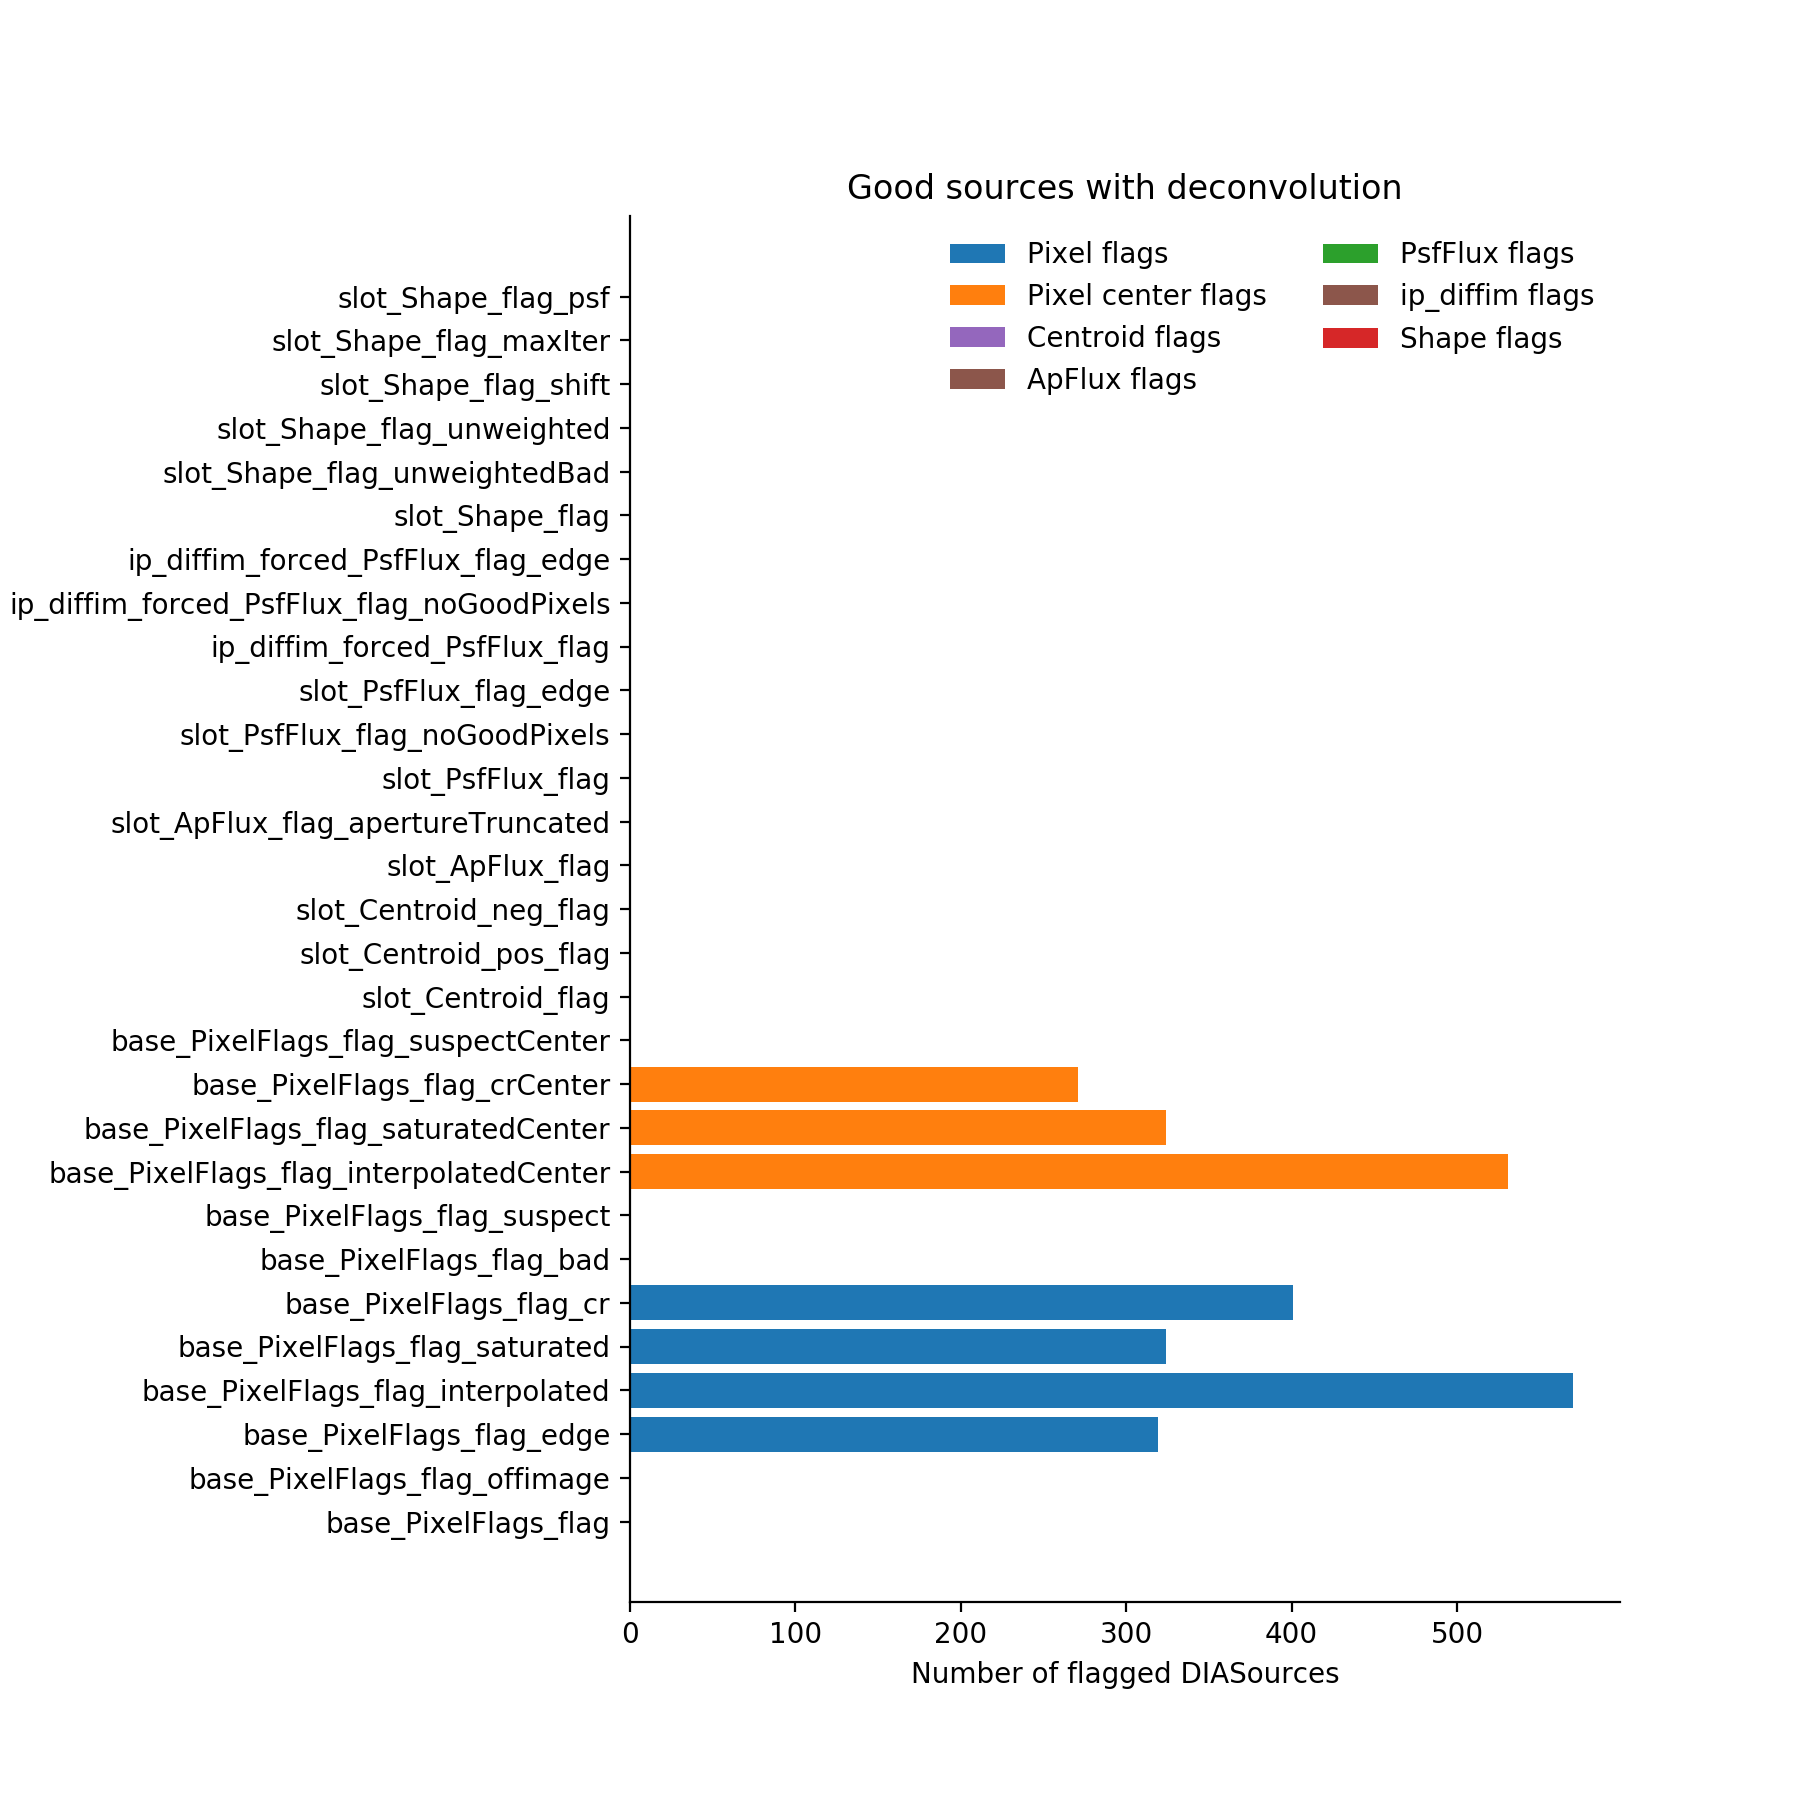

In [74]:
plotFlagHist(miniGoodSrcDf.loc[miniGoodSrcDf['deconvoluted'] == True], title='Good sources with deconvolution')

<IPython.core.display.Javascript object>


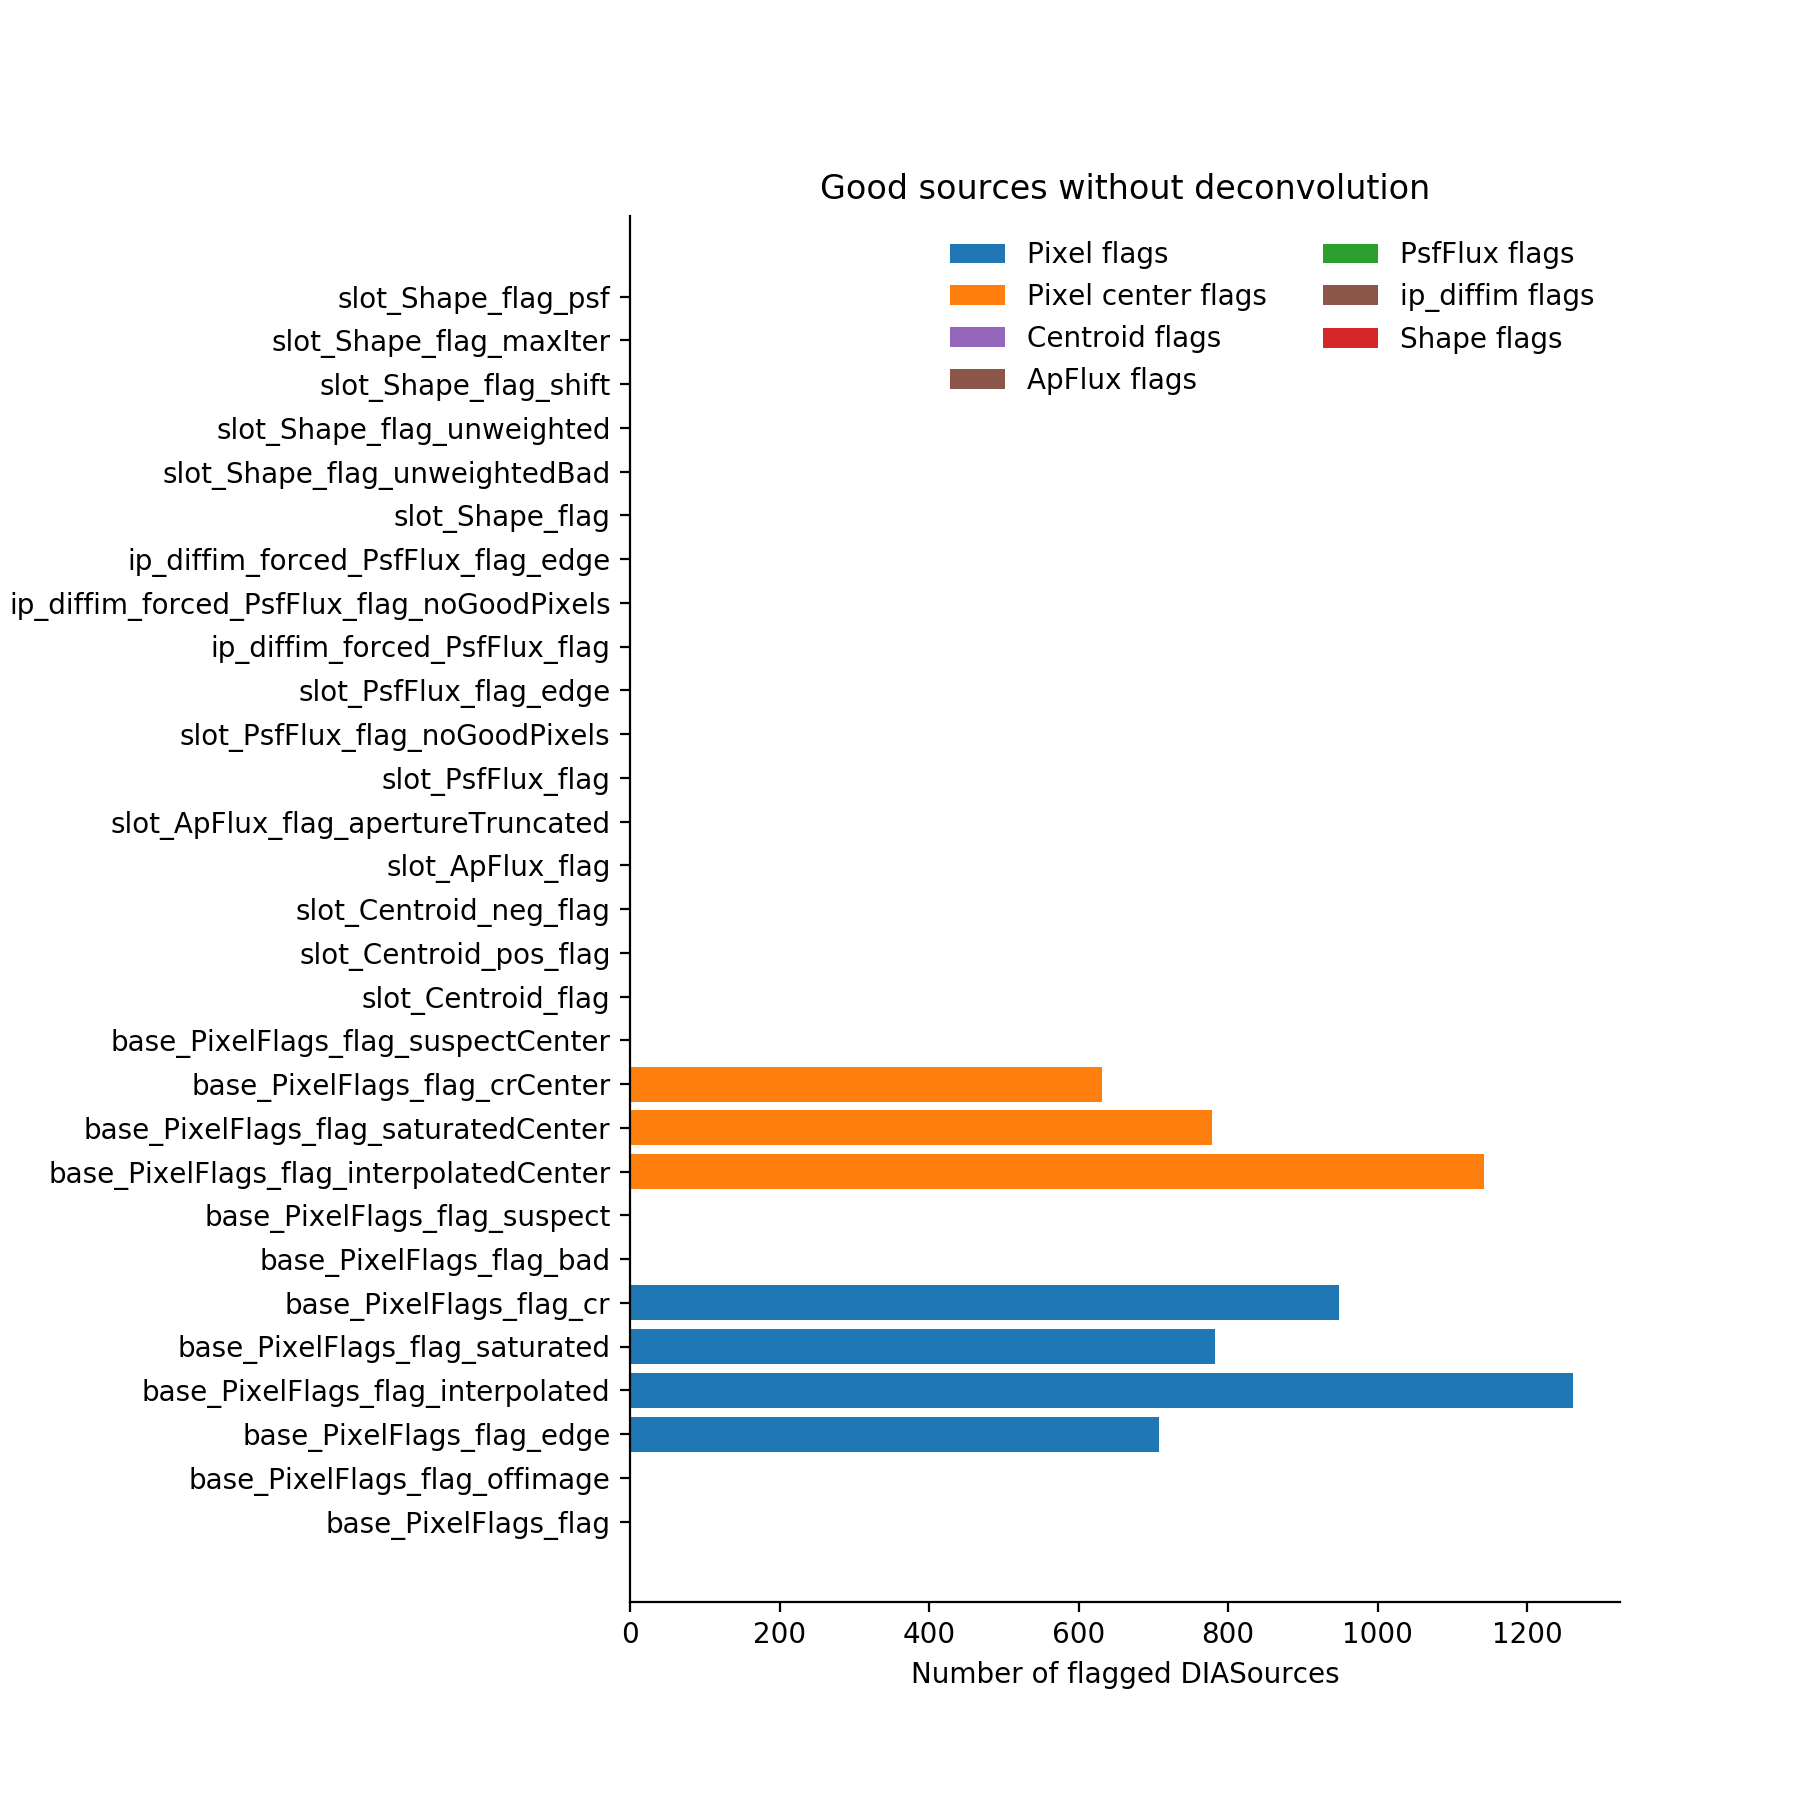

In [73]:
plotFlagHist(miniGoodSrcDf.loc[miniGoodSrcDf['deconvoluted'] == False], title='Good sources without deconvolution')

<IPython.core.display.Javascript object>


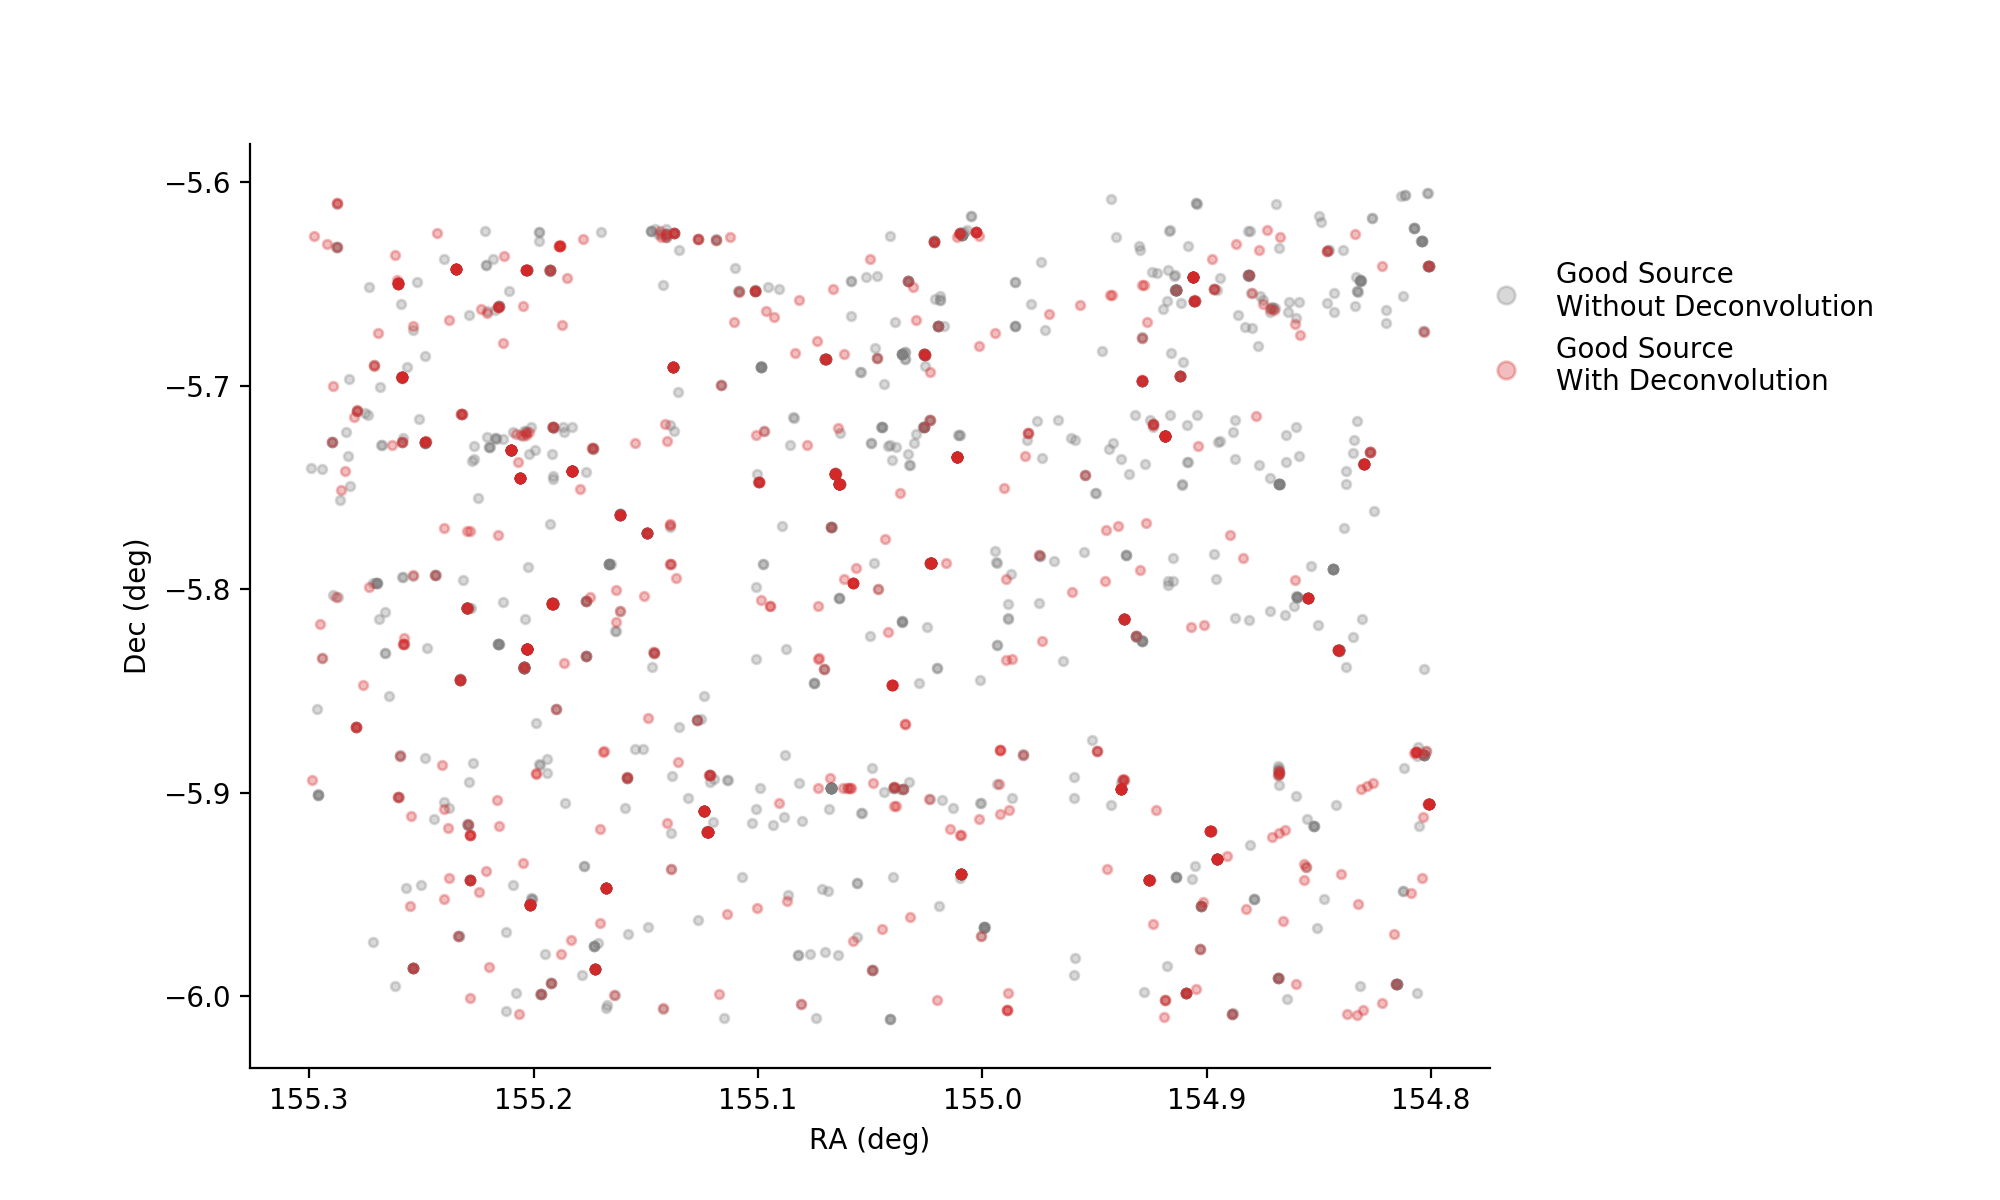

In [87]:
fig, ax = plt.subplots(figsize=(10,6))

scatterGoodSrc1 = ax.scatter(miniGoodSrcDf.loc[miniGoodSrcDf['deconvoluted'] == False,'ra'], 
                             miniGoodSrcDf.loc[miniGoodSrcDf['deconvoluted'] == False, 'decl'], 
                             c='C7', s=10, alpha=0.3, label='Good Source \nWithout Deconvolution')
scatterGoodSrc2 = ax.scatter(miniGoodSrcDf.loc[miniGoodSrcDf['deconvoluted'] == True,'ra'], 
                             miniGoodSrcDf.loc[miniGoodSrcDf['deconvoluted'] == True, 'decl'], 
                             c='C3', s=10, alpha=0.3, label='Good Source \nWith Deconvolution')

#scatterGoodObj = ax.scatter(miniGoodObjDf.loc[(miniGoodObjDf['nDiaSources'] >= 20), 'ra'], 
#                            miniGoodObjDf.loc[(miniGoodObjDf['nDiaSources'] >= 20),'decl'], 
#                            c='C0', s=20, alpha=0.3, label='Good Object \nwith >=20 Sources')

ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_xaxis()

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(bbox_to_anchor=(0.97, 0.9), frameon=False, markerscale=2)

I don't see any obvious difference in terms of flag counts or spatial distribution between sources with/without deconvolution.

In [89]:
goodObjIdsDecon = set(miniGoodSrcDf.loc[miniGoodSrcDf['deconvoluted'] == True, 'diaObjectId'])

In [91]:
goodObjIdsNoDecon = set(miniGoodSrcDf.loc[miniGoodSrcDf['deconvoluted'] == False, 'diaObjectId'])

Exclude objects which have a combination of devonvolved + non-deconvolved sources

In [112]:
goodObjIdsDeconExclusive = [obj for obj in list(goodObjIdsDecon) if obj not in goodObjIdsNoDecon]
goodObjIdsNoDeconExclusive = [obj for obj in list(goodObjIdsNoDecon) if obj not in goodObjIdsDecon]

In [94]:
print(len(list(goodObjDeconList)), len(list(goodObjIdsNoDecon)))

356 598


In [113]:
print(len(goodObjIdsDeconExclusive), len(goodObjIdsNoDeconExclusive))

220 462


Two object dataframes where each object has at least 20 sources, and **all** of those sources are deconvolved or not

In [114]:
miniGoodObjDfDeconMult = miniGoodObjDf.loc[(miniGoodObjDf['nDiaSources'] >= 20) & 
                                           (miniGoodObjDf['diaObjectId'].isin(goodObjIdsDeconExclusive))]
miniGoodObjDfNoDeconMult = miniGoodObjDf.loc[(miniGoodObjDf['nDiaSources'] >= 20) & 
                                             (miniGoodObjDf['diaObjectId'].isin(goodObjIdsNoDeconExclusive))]

In [115]:
print(len(miniGoodObjDfDeconMult), len(miniGoodObjDfNoDeconMult))

8 56


<IPython.core.display.Javascript object>


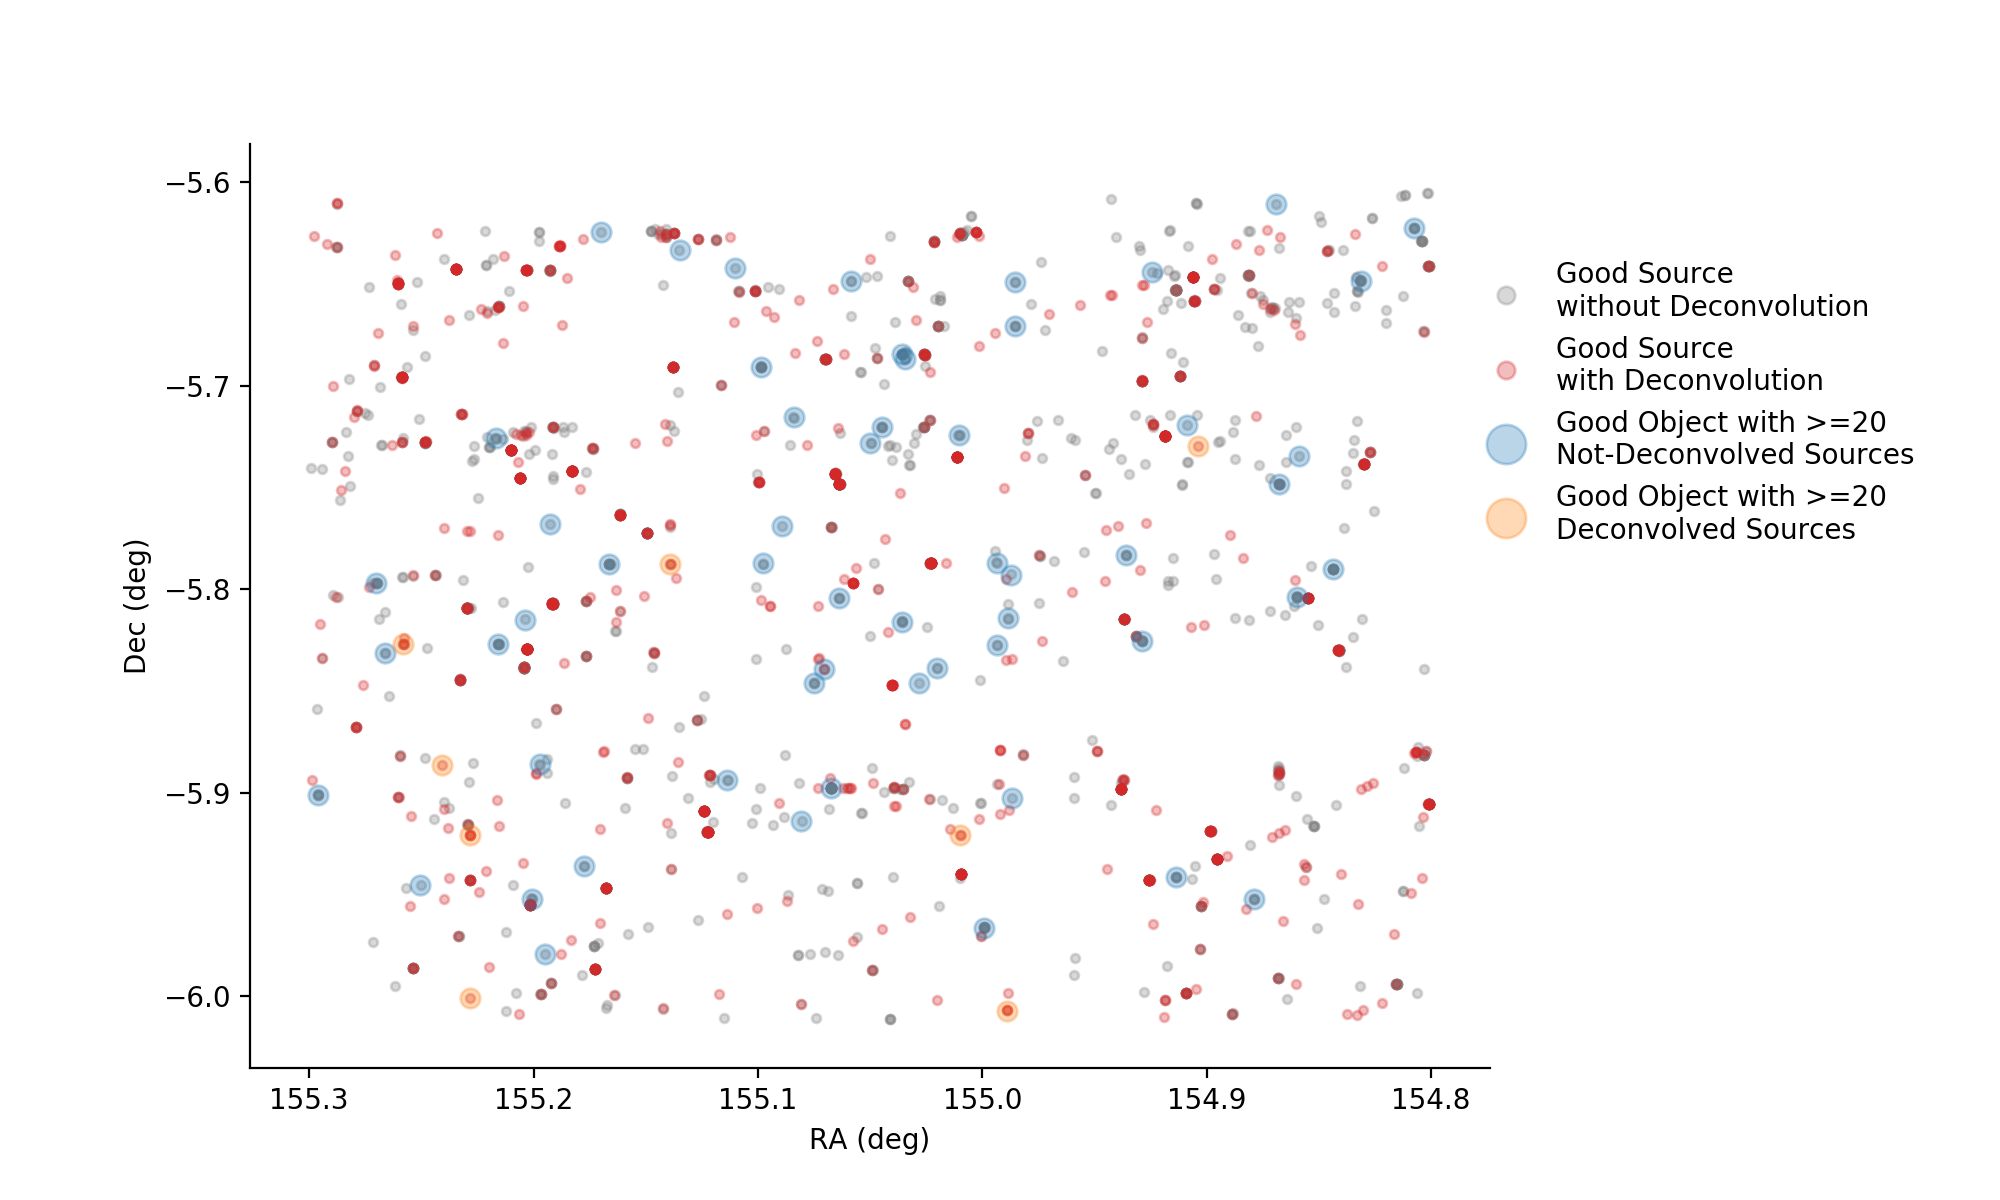

In [121]:
fig, ax = plt.subplots(figsize=(10,6))

scatterGoodSrc1 = ax.scatter(miniGoodSrcDf.loc[miniGoodSrcDf['deconvoluted'] == False,'ra'], 
                             miniGoodSrcDf.loc[miniGoodSrcDf['deconvoluted'] == False, 'decl'], 
                             c='C7', s=10, alpha=0.3, label='Good Source \nwithout Deconvolution')
scatterGoodSrc2 = ax.scatter(miniGoodSrcDf.loc[miniGoodSrcDf['deconvoluted'] == True,'ra'], 
                             miniGoodSrcDf.loc[miniGoodSrcDf['deconvoluted'] == True, 'decl'], 
                             c='C3', s=10, alpha=0.3, label='Good Source \nwith Deconvolution')

scatterGoodObj2 = ax.scatter(miniGoodObjDfNoDeconMult['ra'], 
                             miniGoodObjDfNoDeconMult['decl'], 
                             c='C0', s=50, alpha=0.3, label='Good Object with >=20 \nNot-Deconvolved Sources')

scatterGoodObj1 = ax.scatter(miniGoodObjDfDeconMult['ra'], 
                             miniGoodObjDfDeconMult['decl'], 
                             c='C1', s=50, alpha=0.3, label='Good Object with >=20 \nDeconvolved Sources')

ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.invert_xaxis()

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(bbox_to_anchor=(0.97, 0.9), frameon=False, markerscale=2)

In [99]:
patchList = ['10,8', '11,8', '12,8', '13,8',
             '10,7', '11,7', '12,7', '13,7',
             '10,9', '11,9', '12,9', '13,9',
             '10,5', '11,5', '12,5', '13,5',
             '10,6', '11,6', '12,6', '13,6',
             '10,10', '11,10', '12,10', '13,10']

### Light curves for a few objects where all sources do have deconvolution

Loading PPDB Sources...
DIAObject ID: 176492704547471520
RA (deg): [154.9890243]
Dec (deg): [-6.00699829]
Number of DIASources: 24
Template patch: 11,7


<IPython.core.display.Javascript object>


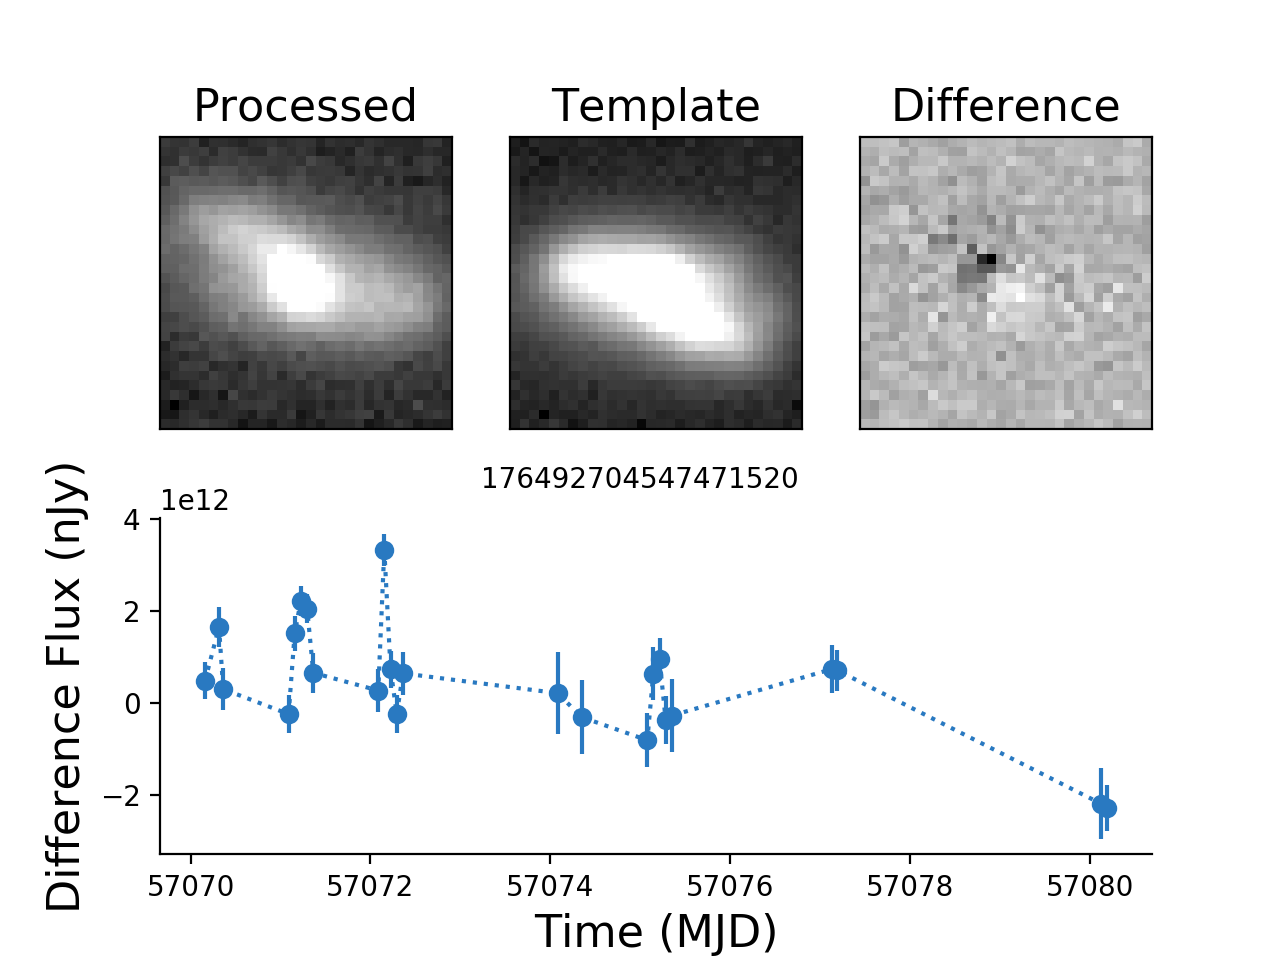

<IPython.core.display.Javascript object>


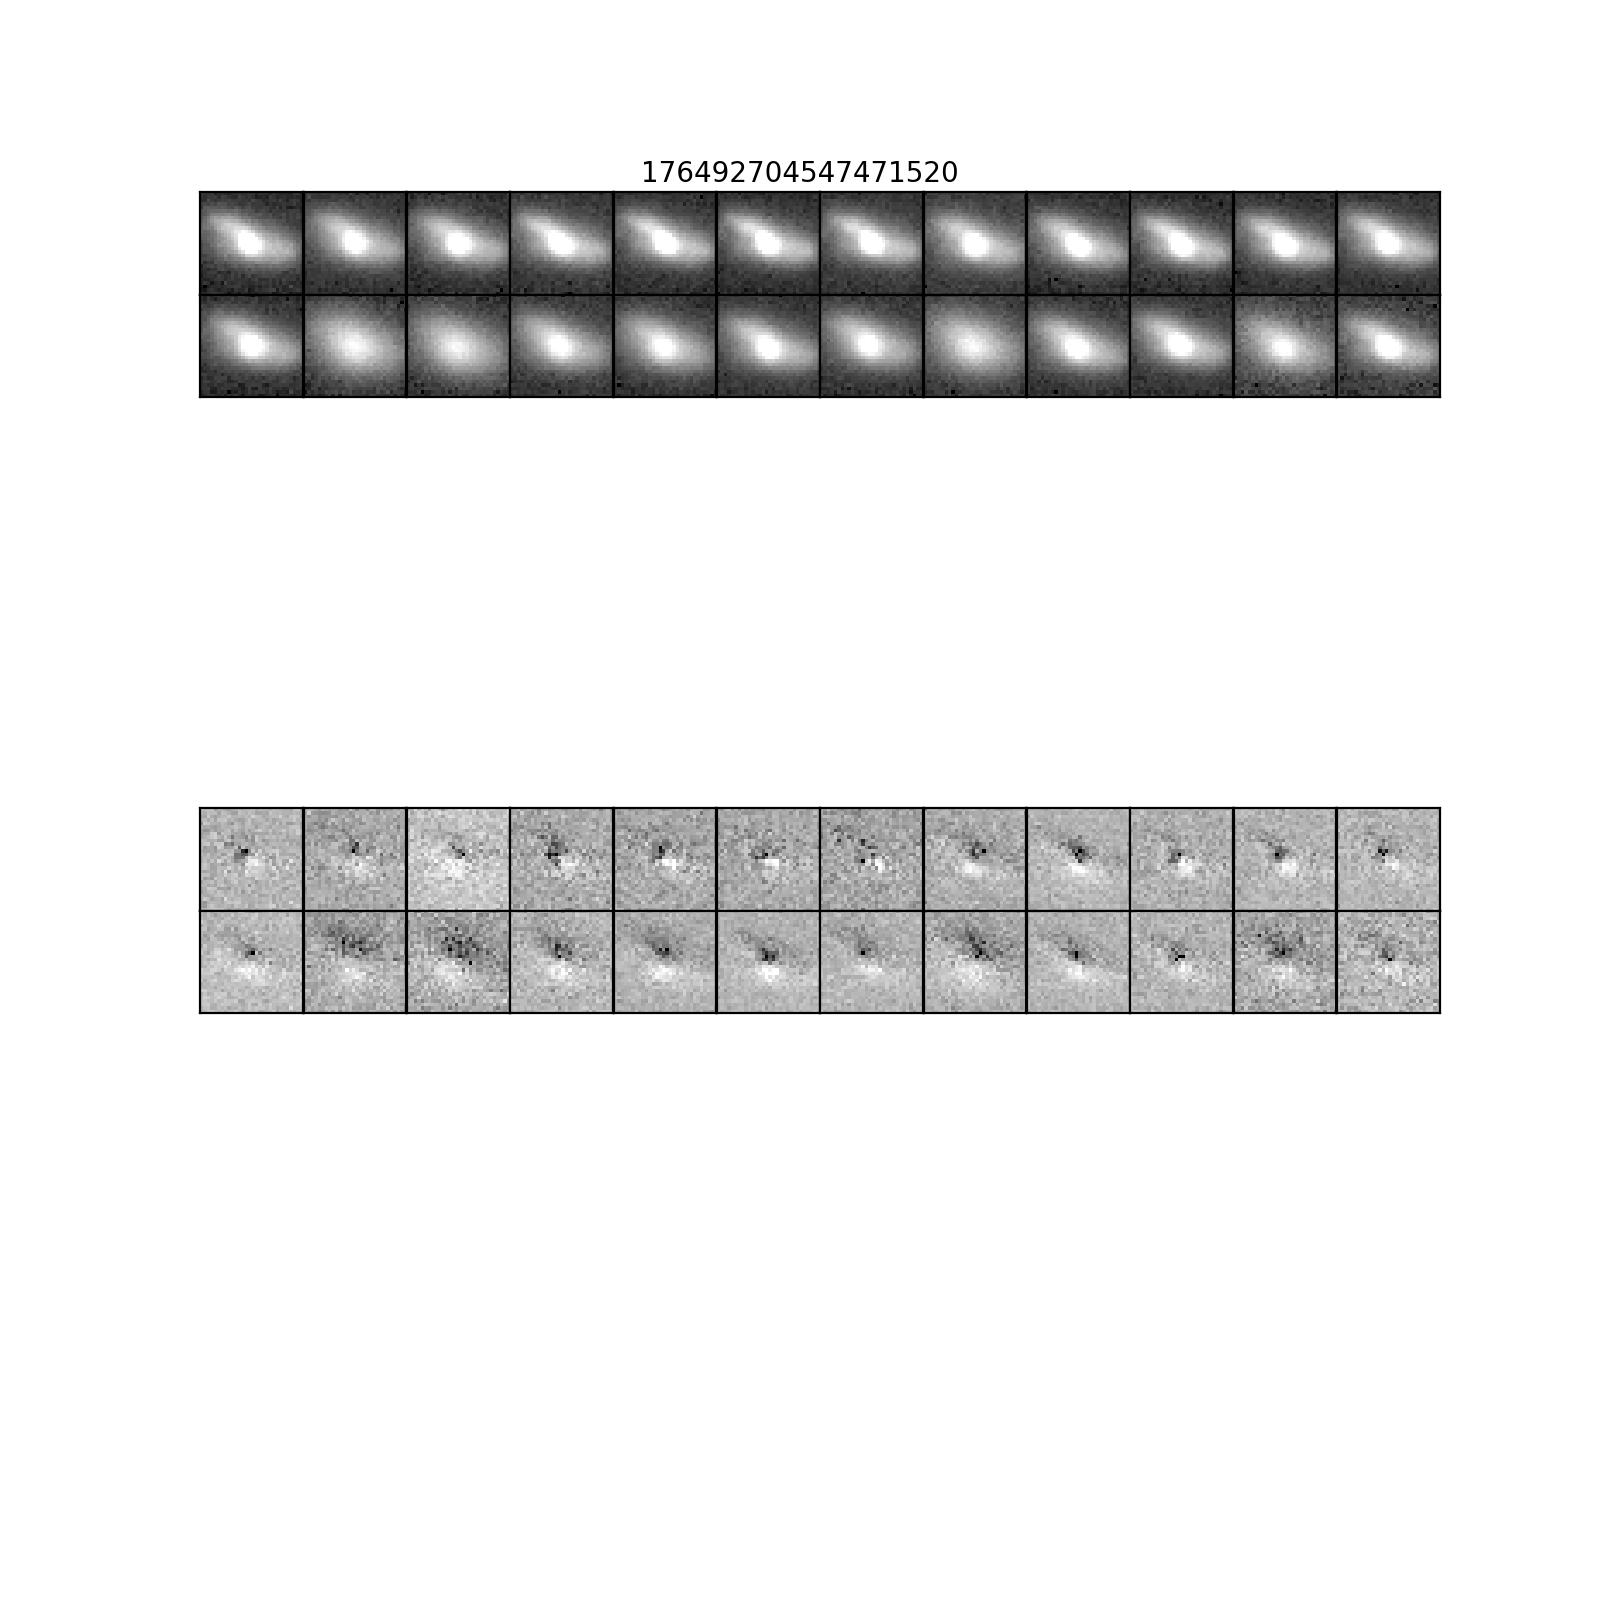

Loading PPDB Sources...
DIAObject ID: 176493778289295520
RA (deg): [155.00976983]
Dec (deg): [-5.92051779]
Number of DIASources: 20
Template patch: 11,7


<IPython.core.display.Javascript object>


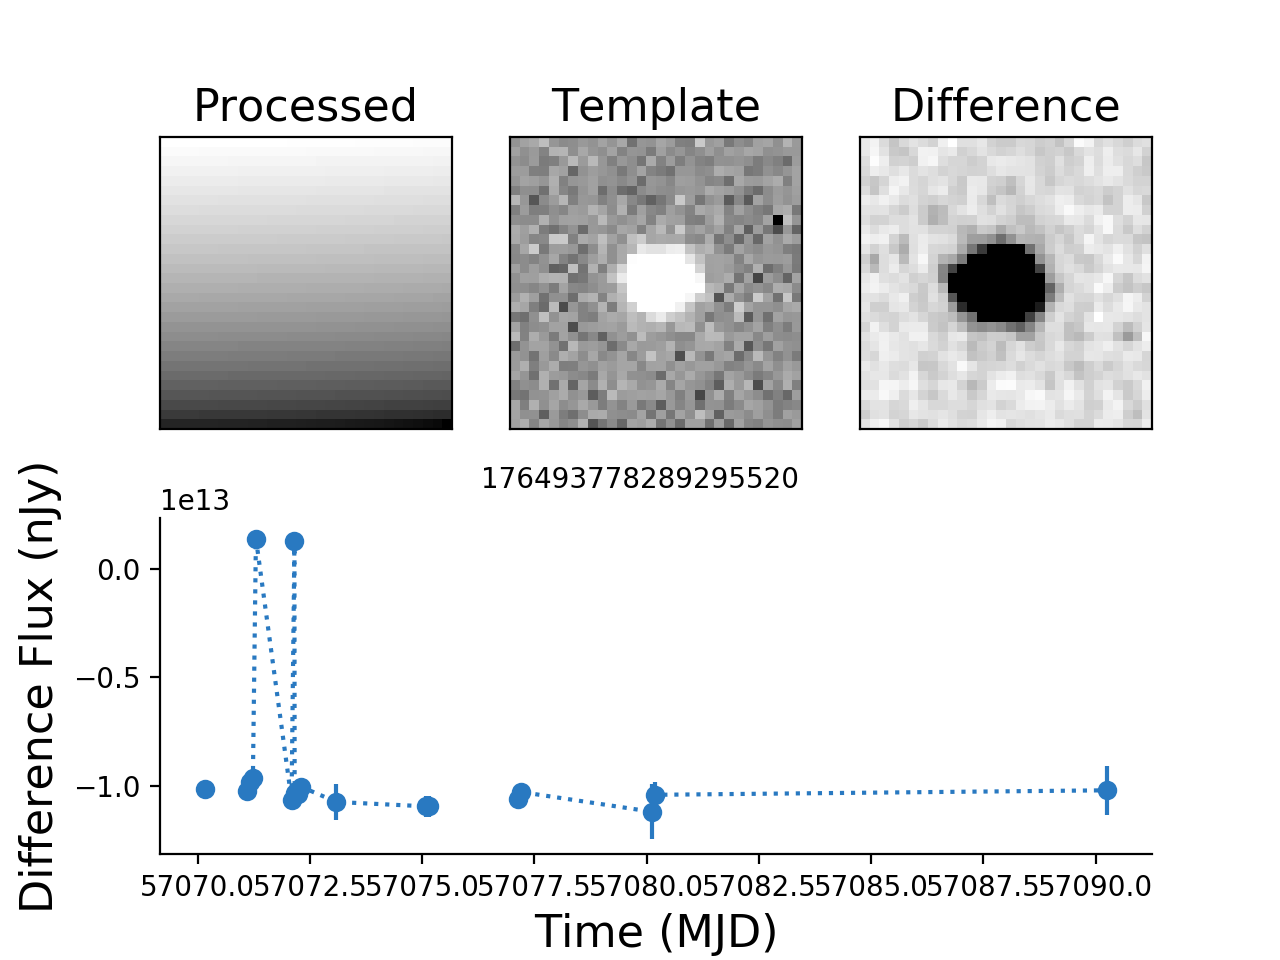

<IPython.core.display.Javascript object>


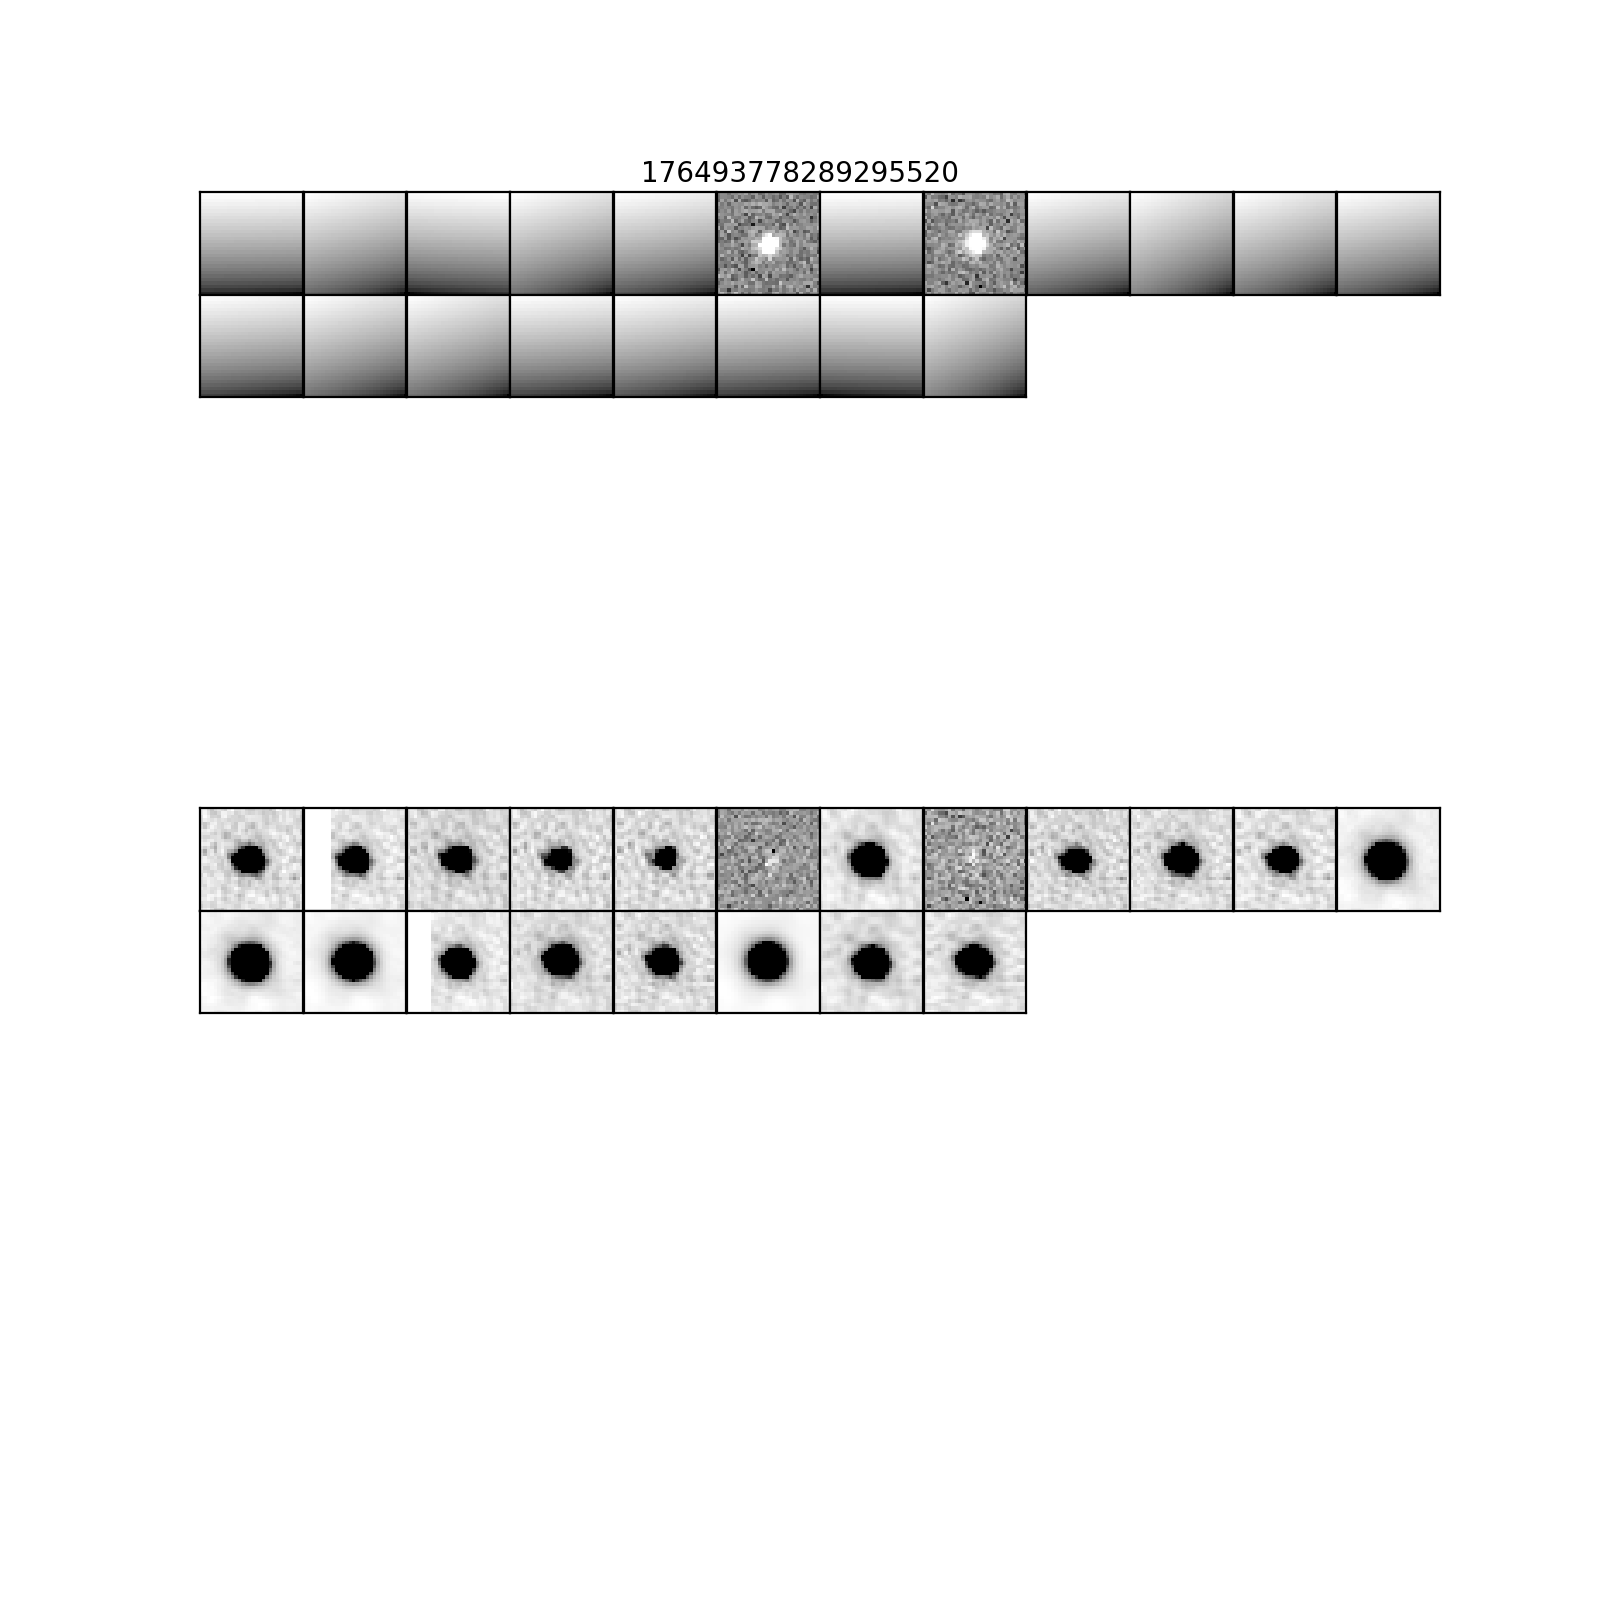

Loading PPDB Sources...
DIAObject ID: 176492704547471593
RA (deg): [155.22826618]
Dec (deg): [-6.00081876]
Number of DIASources: 25
Template patch: 11,7


<IPython.core.display.Javascript object>


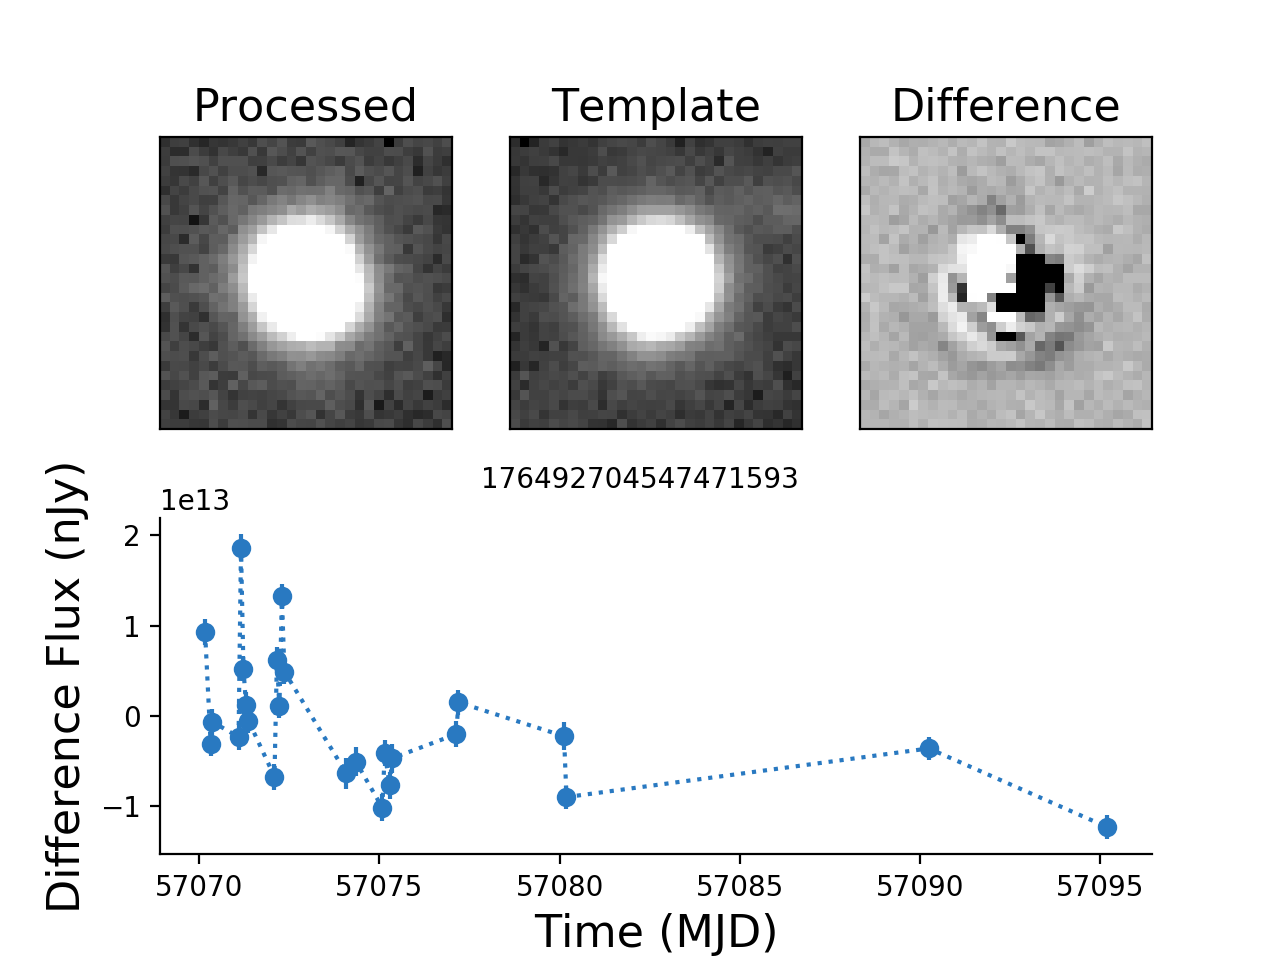

<IPython.core.display.Javascript object>


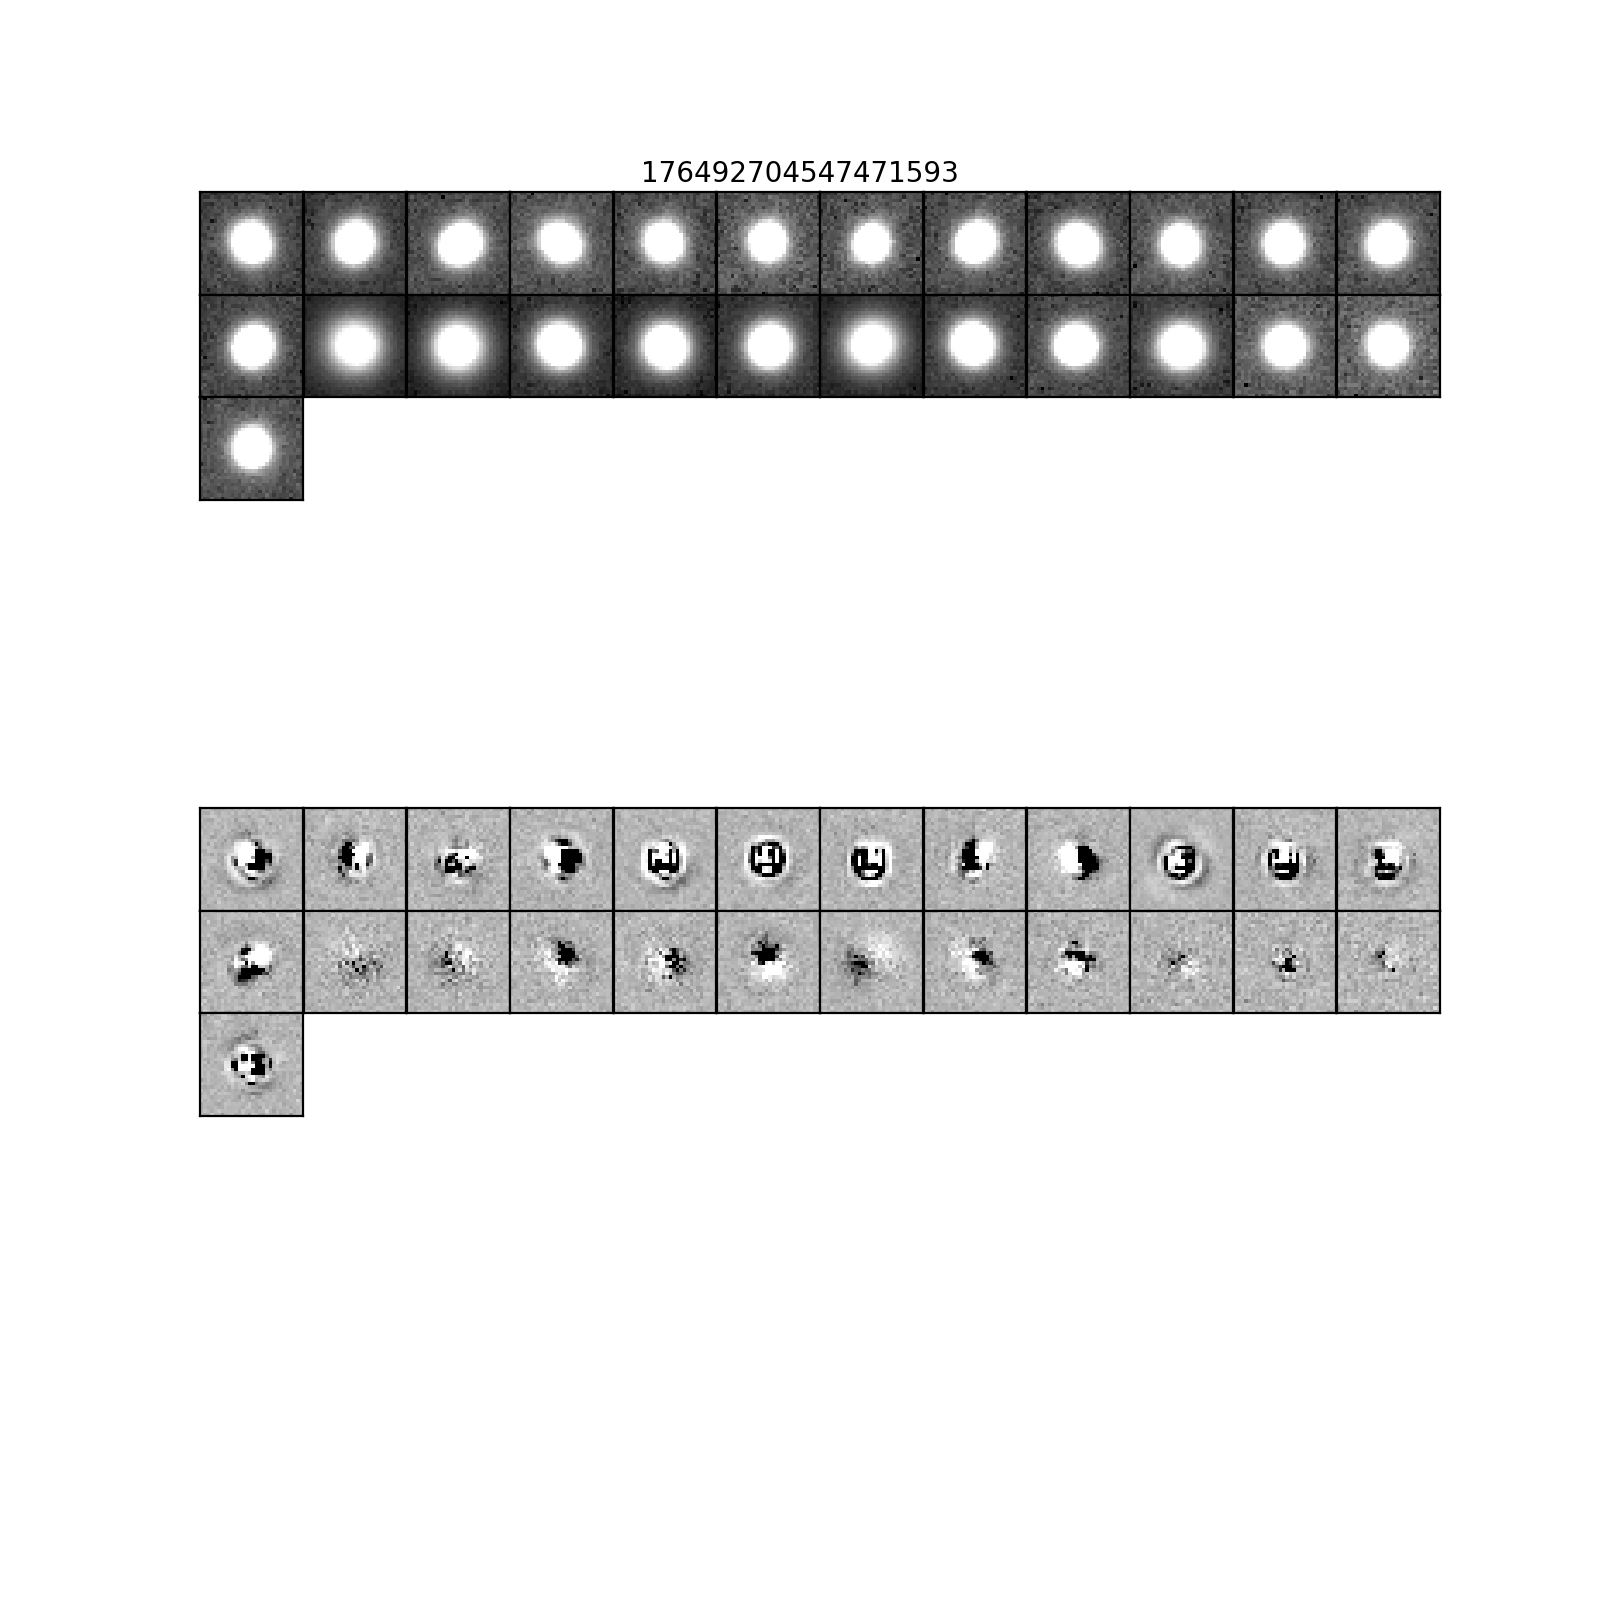

Loading PPDB Sources...
DIAObject ID: 176492683072635178
RA (deg): [154.90374247]
Dec (deg): [-5.72946556]
Number of DIASources: 43
Template patch: 12,8


<IPython.core.display.Javascript object>


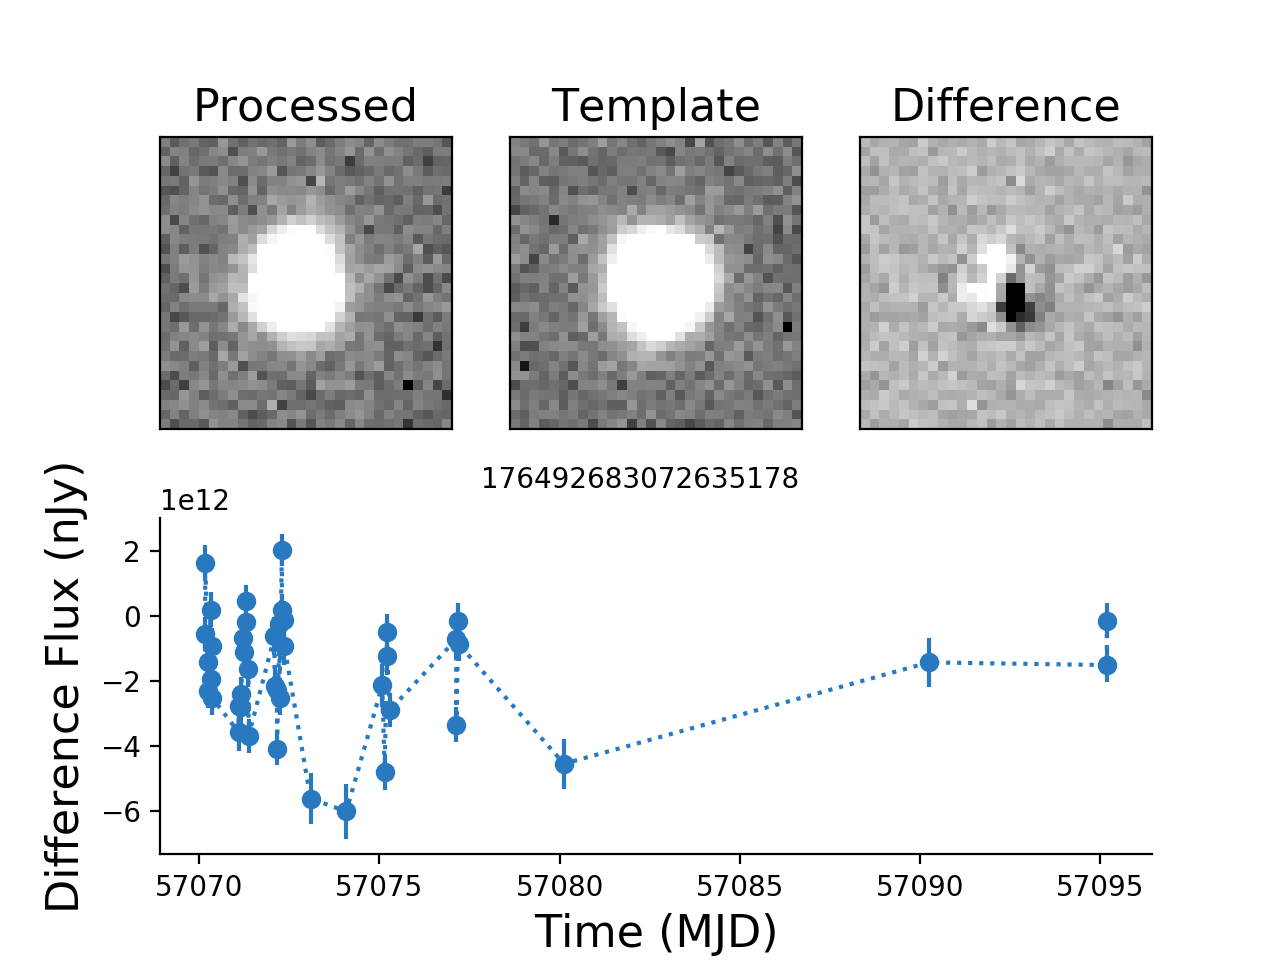

<IPython.core.display.Javascript object>


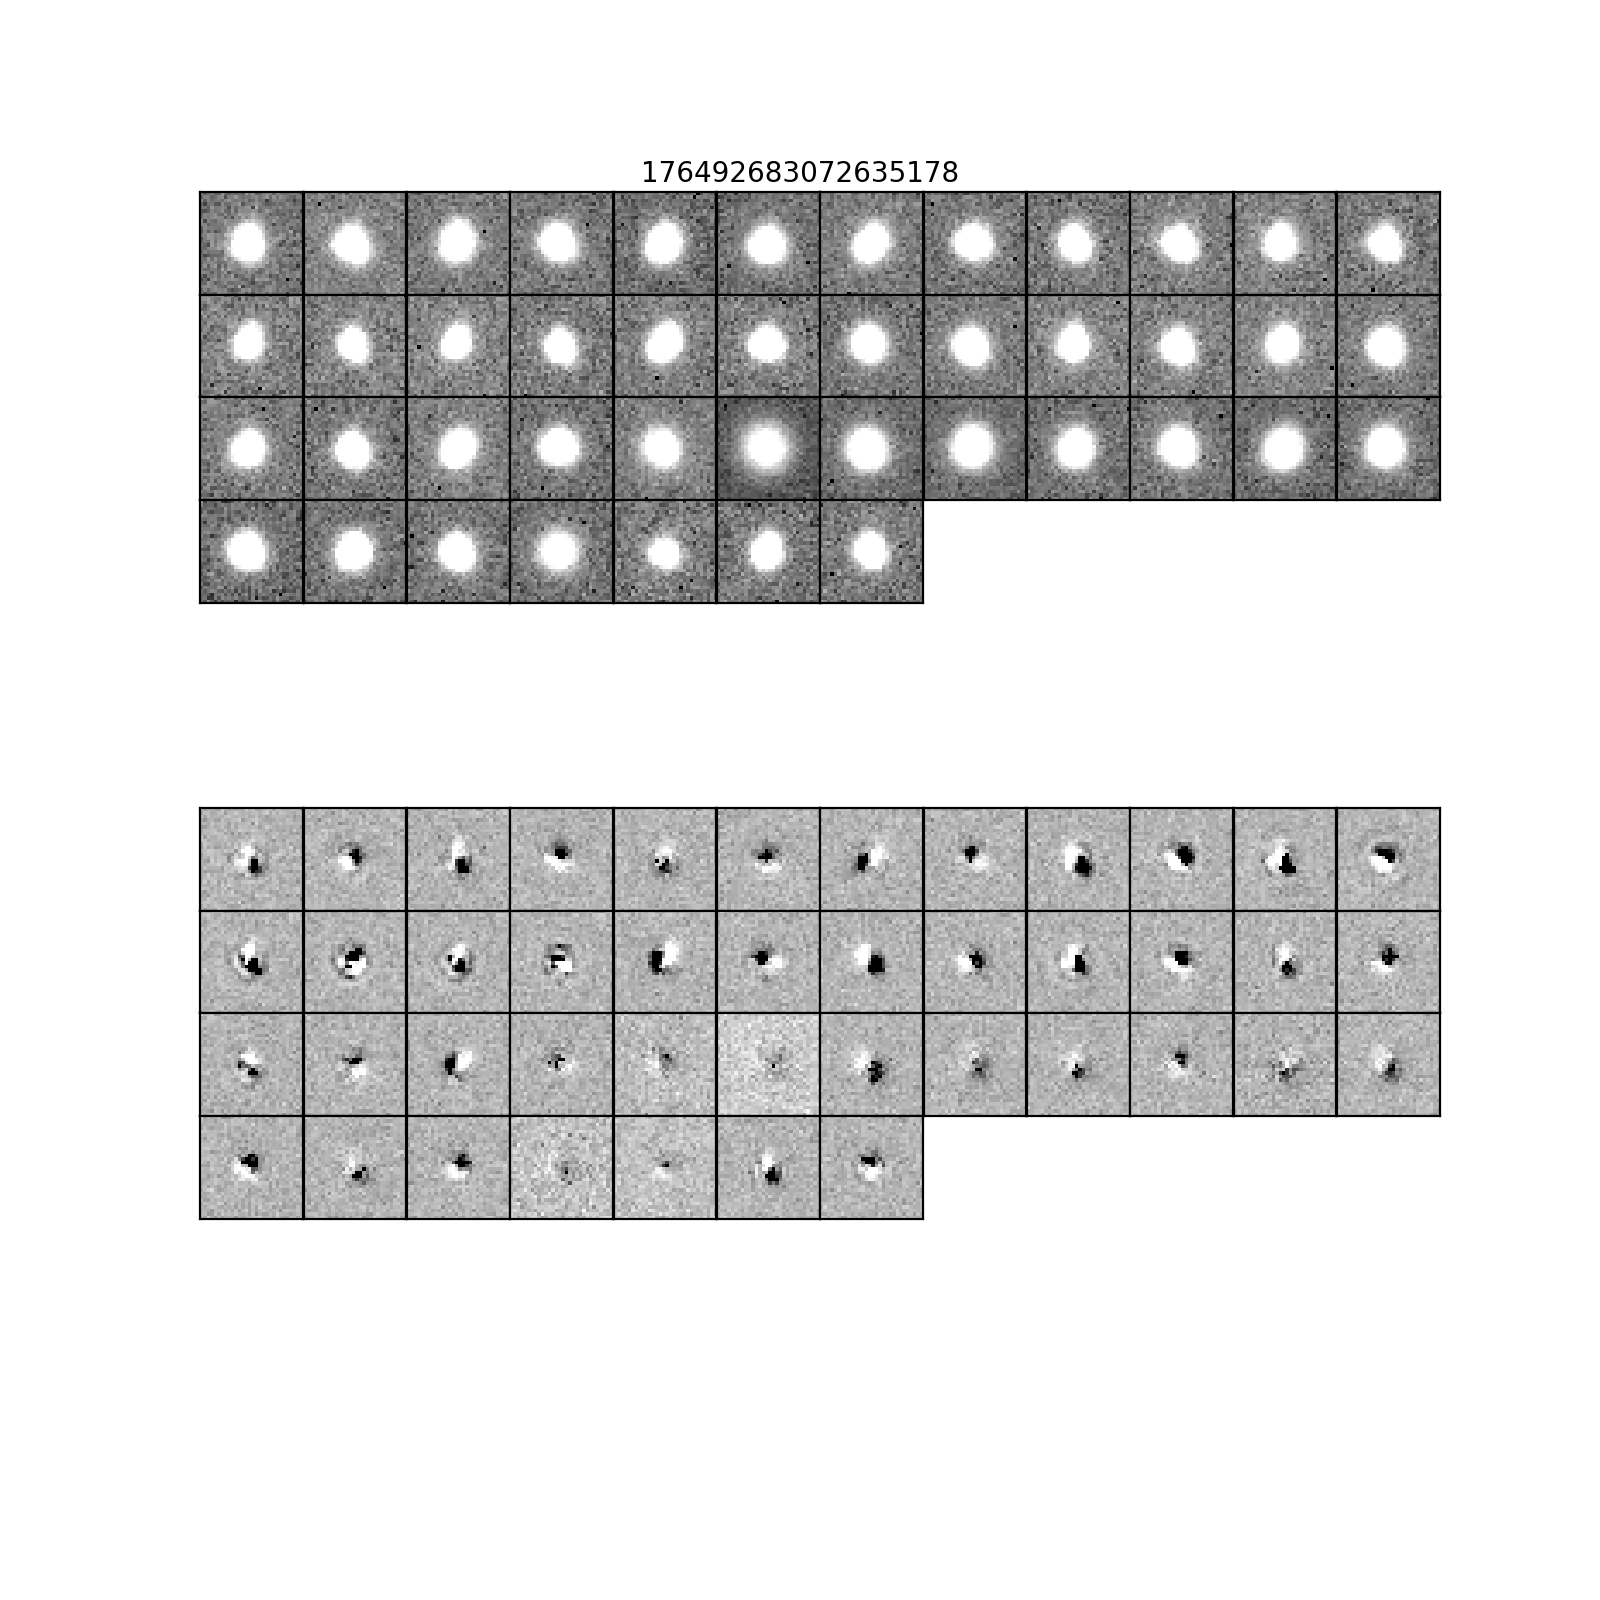

Loading PPDB Sources...
DIAObject ID: 176553907831439571
RA (deg): [155.13896582]
Dec (deg): [-5.78740347]
Number of DIASources: 22
Template patch: 11,8


<IPython.core.display.Javascript object>


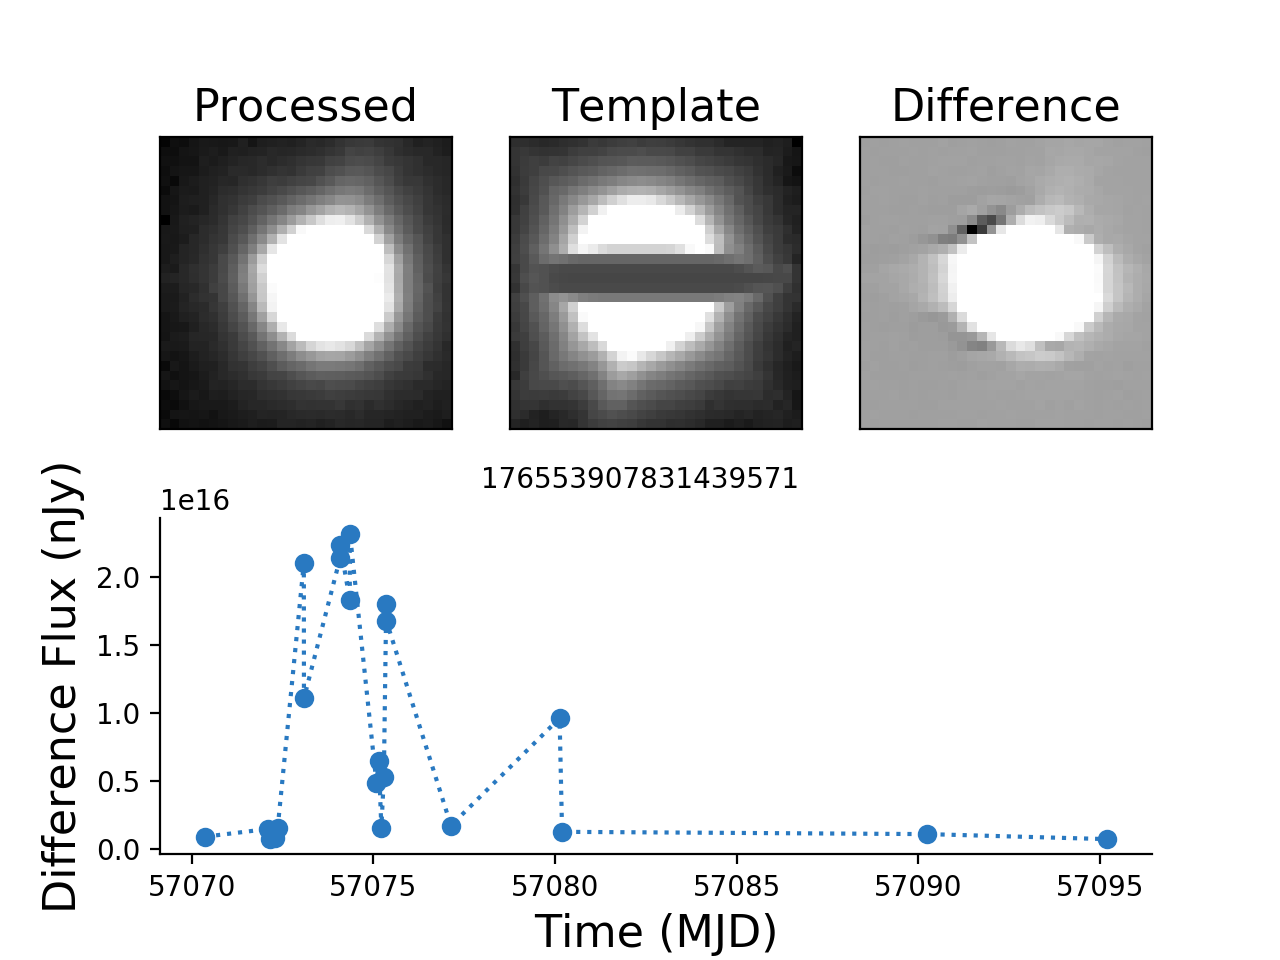

<IPython.core.display.Javascript object>


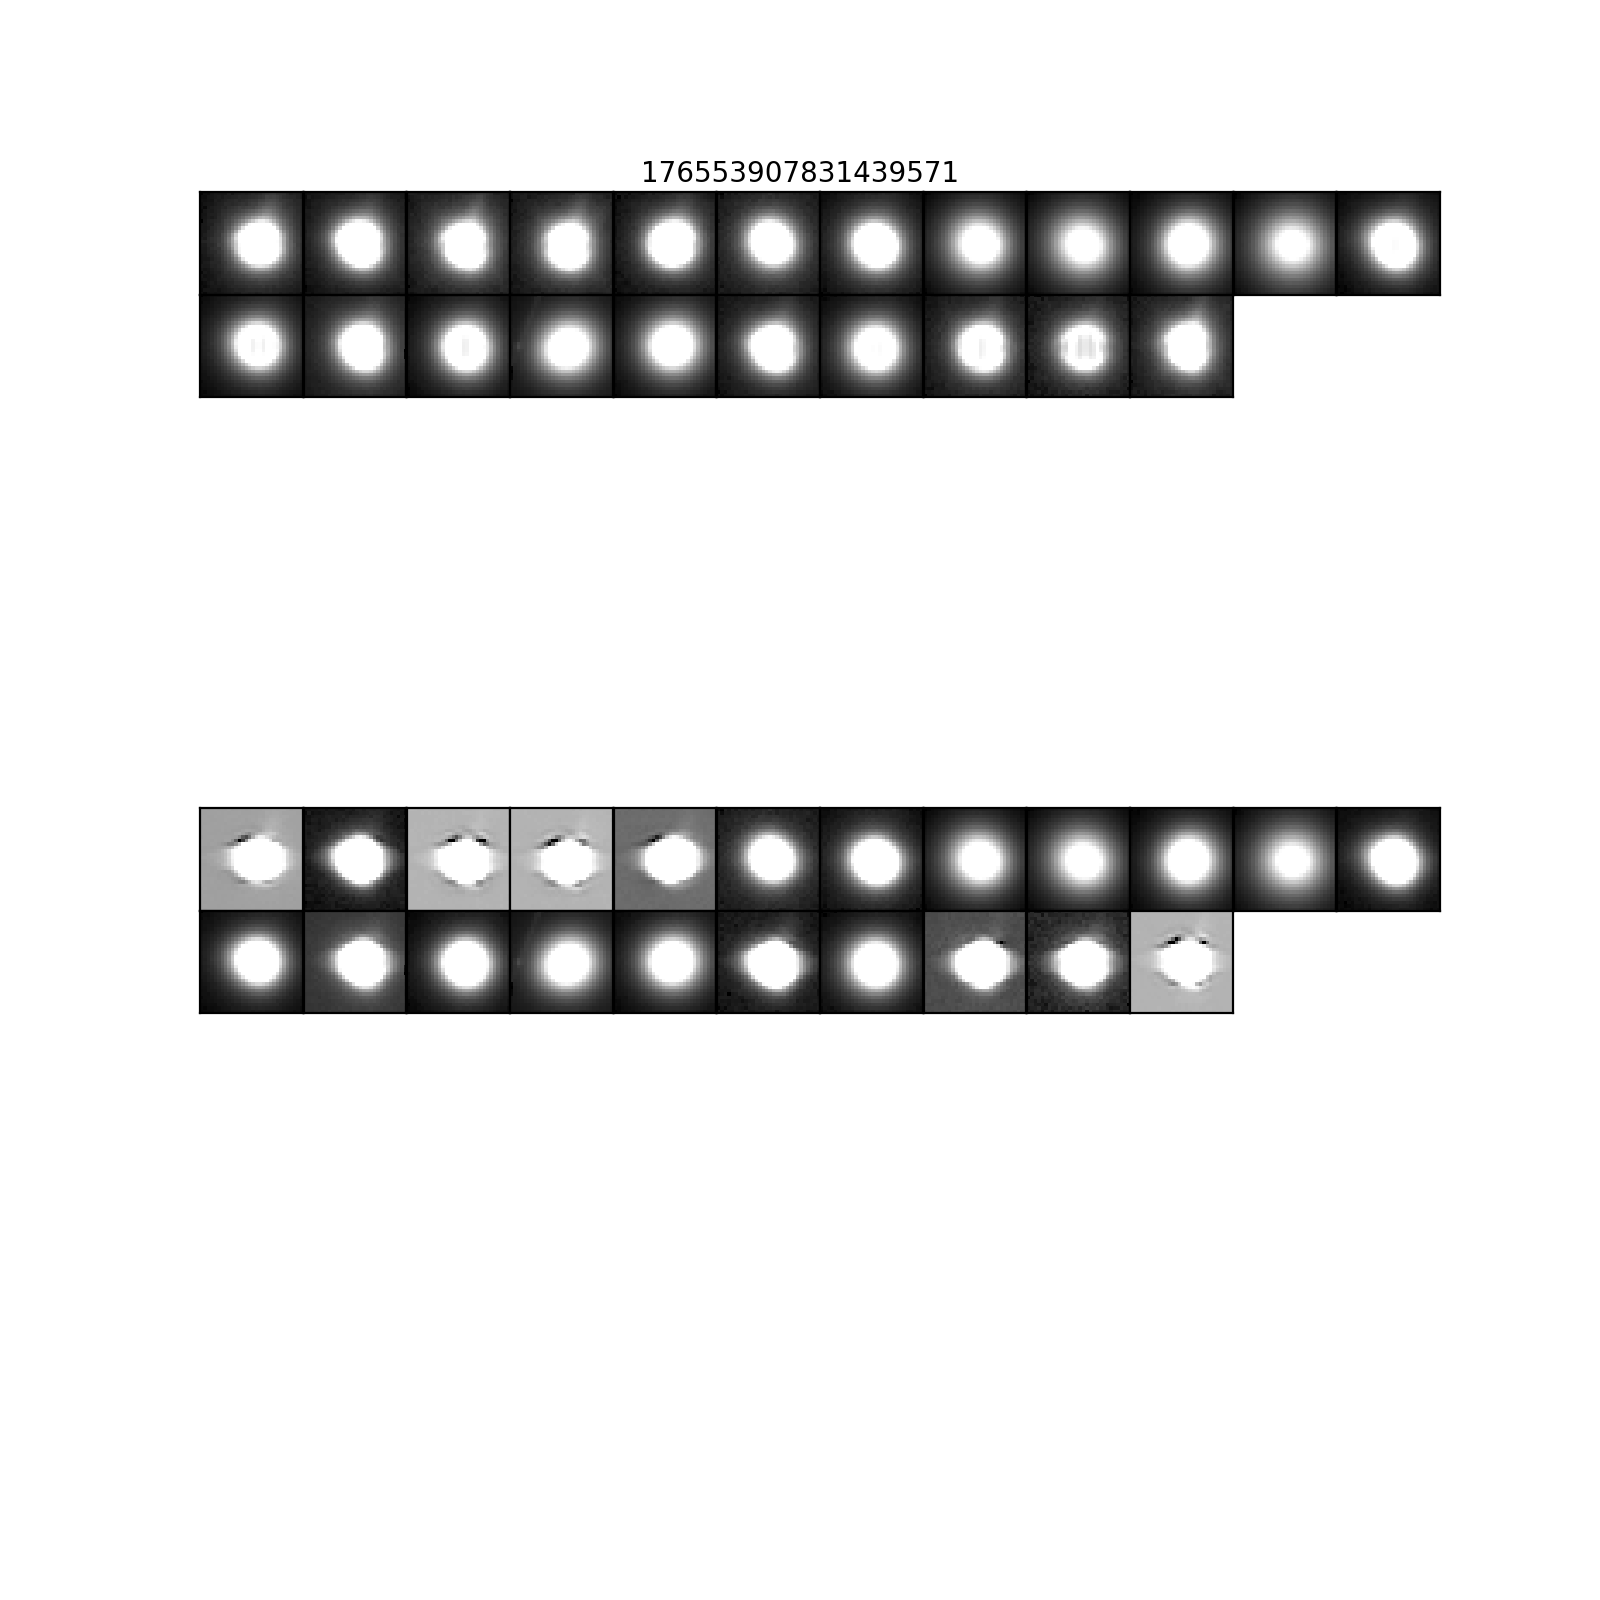

In [127]:
for obj in miniGoodObjDfDeconMult['diaObjectId'].values[0:5]:
    plc.plotLightcurve(obj, miniGoodObjDf, repo, dbPath, repo, patchList, plotAllCutouts=True)

### Light curves for a few objects where all sources have no deconvolution

Loading PPDB Sources...
DIAObject ID: 176492704547471582
RA (deg): [155.1776326]
Dec (deg): [-5.93606994]
Number of DIASources: 21
Template patch: 11,7


<IPython.core.display.Javascript object>


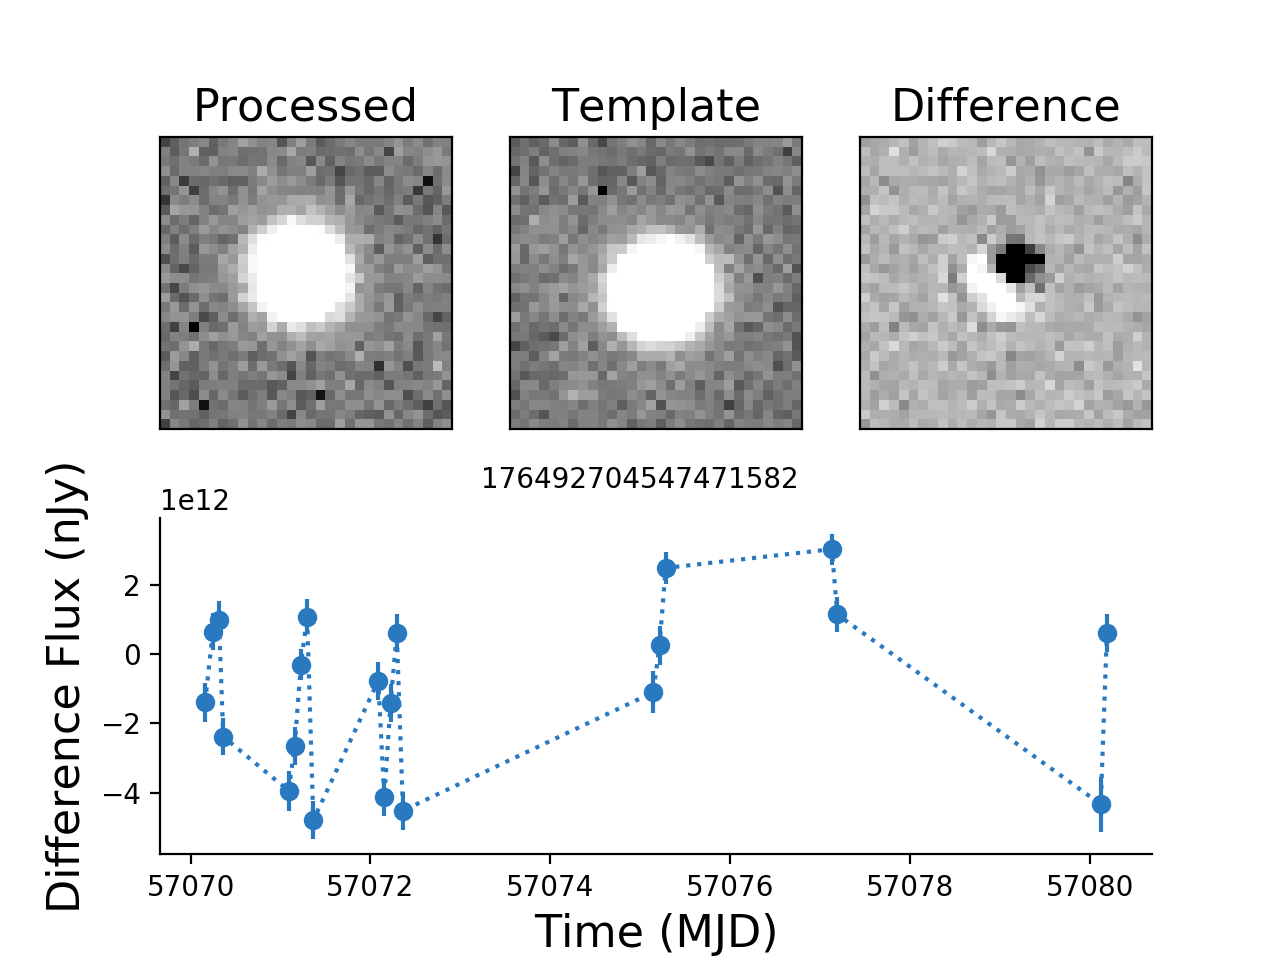

<IPython.core.display.Javascript object>


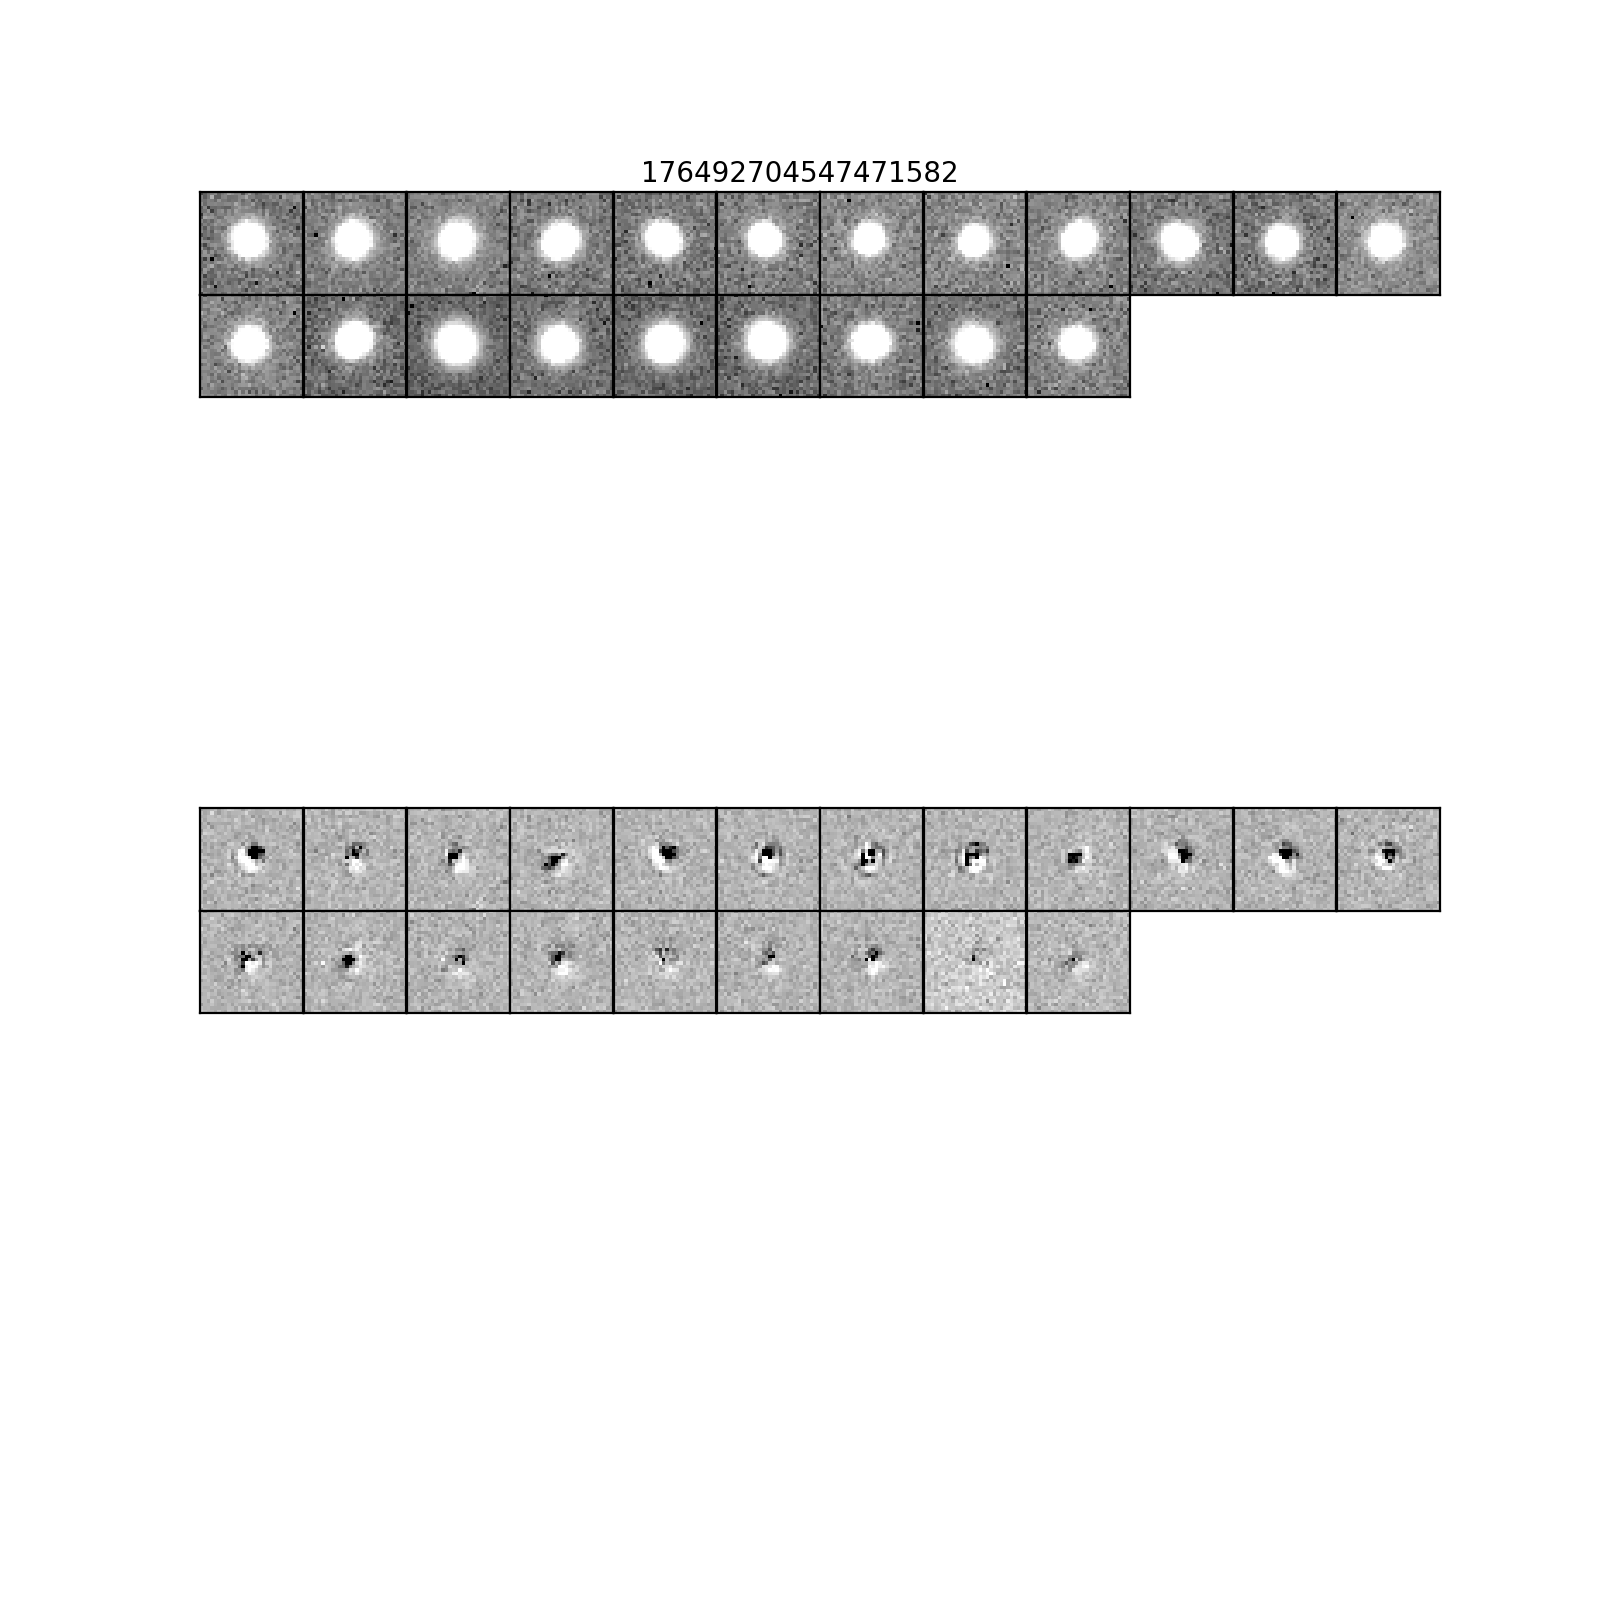

Loading PPDB Sources...
DIAObject ID: 176516734889492760
RA (deg): [154.92871652]
Dec (deg): [-5.82525465]
Number of DIASources: 21
Template patch: 12,7


<IPython.core.display.Javascript object>


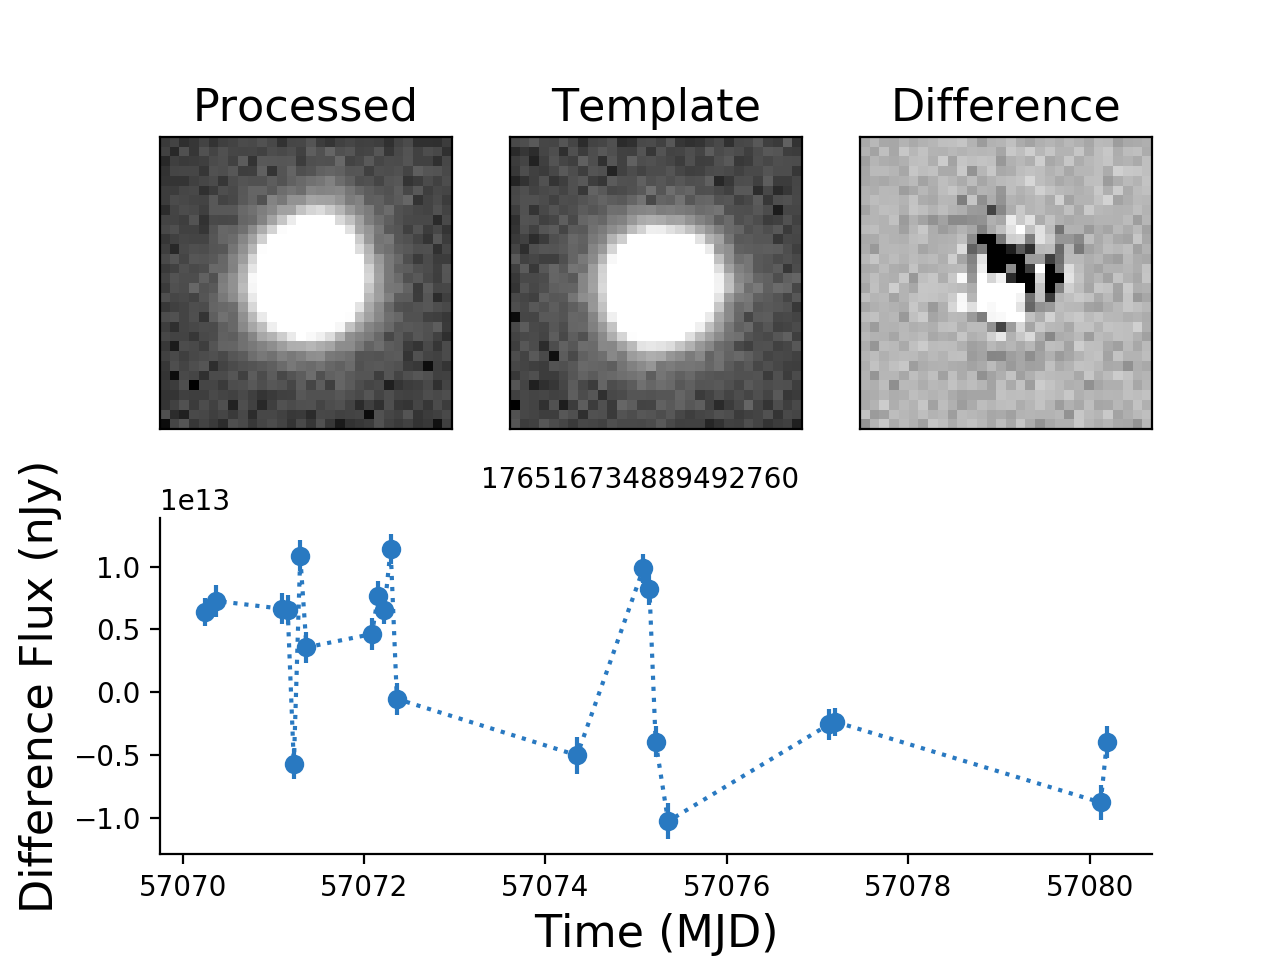

<IPython.core.display.Javascript object>


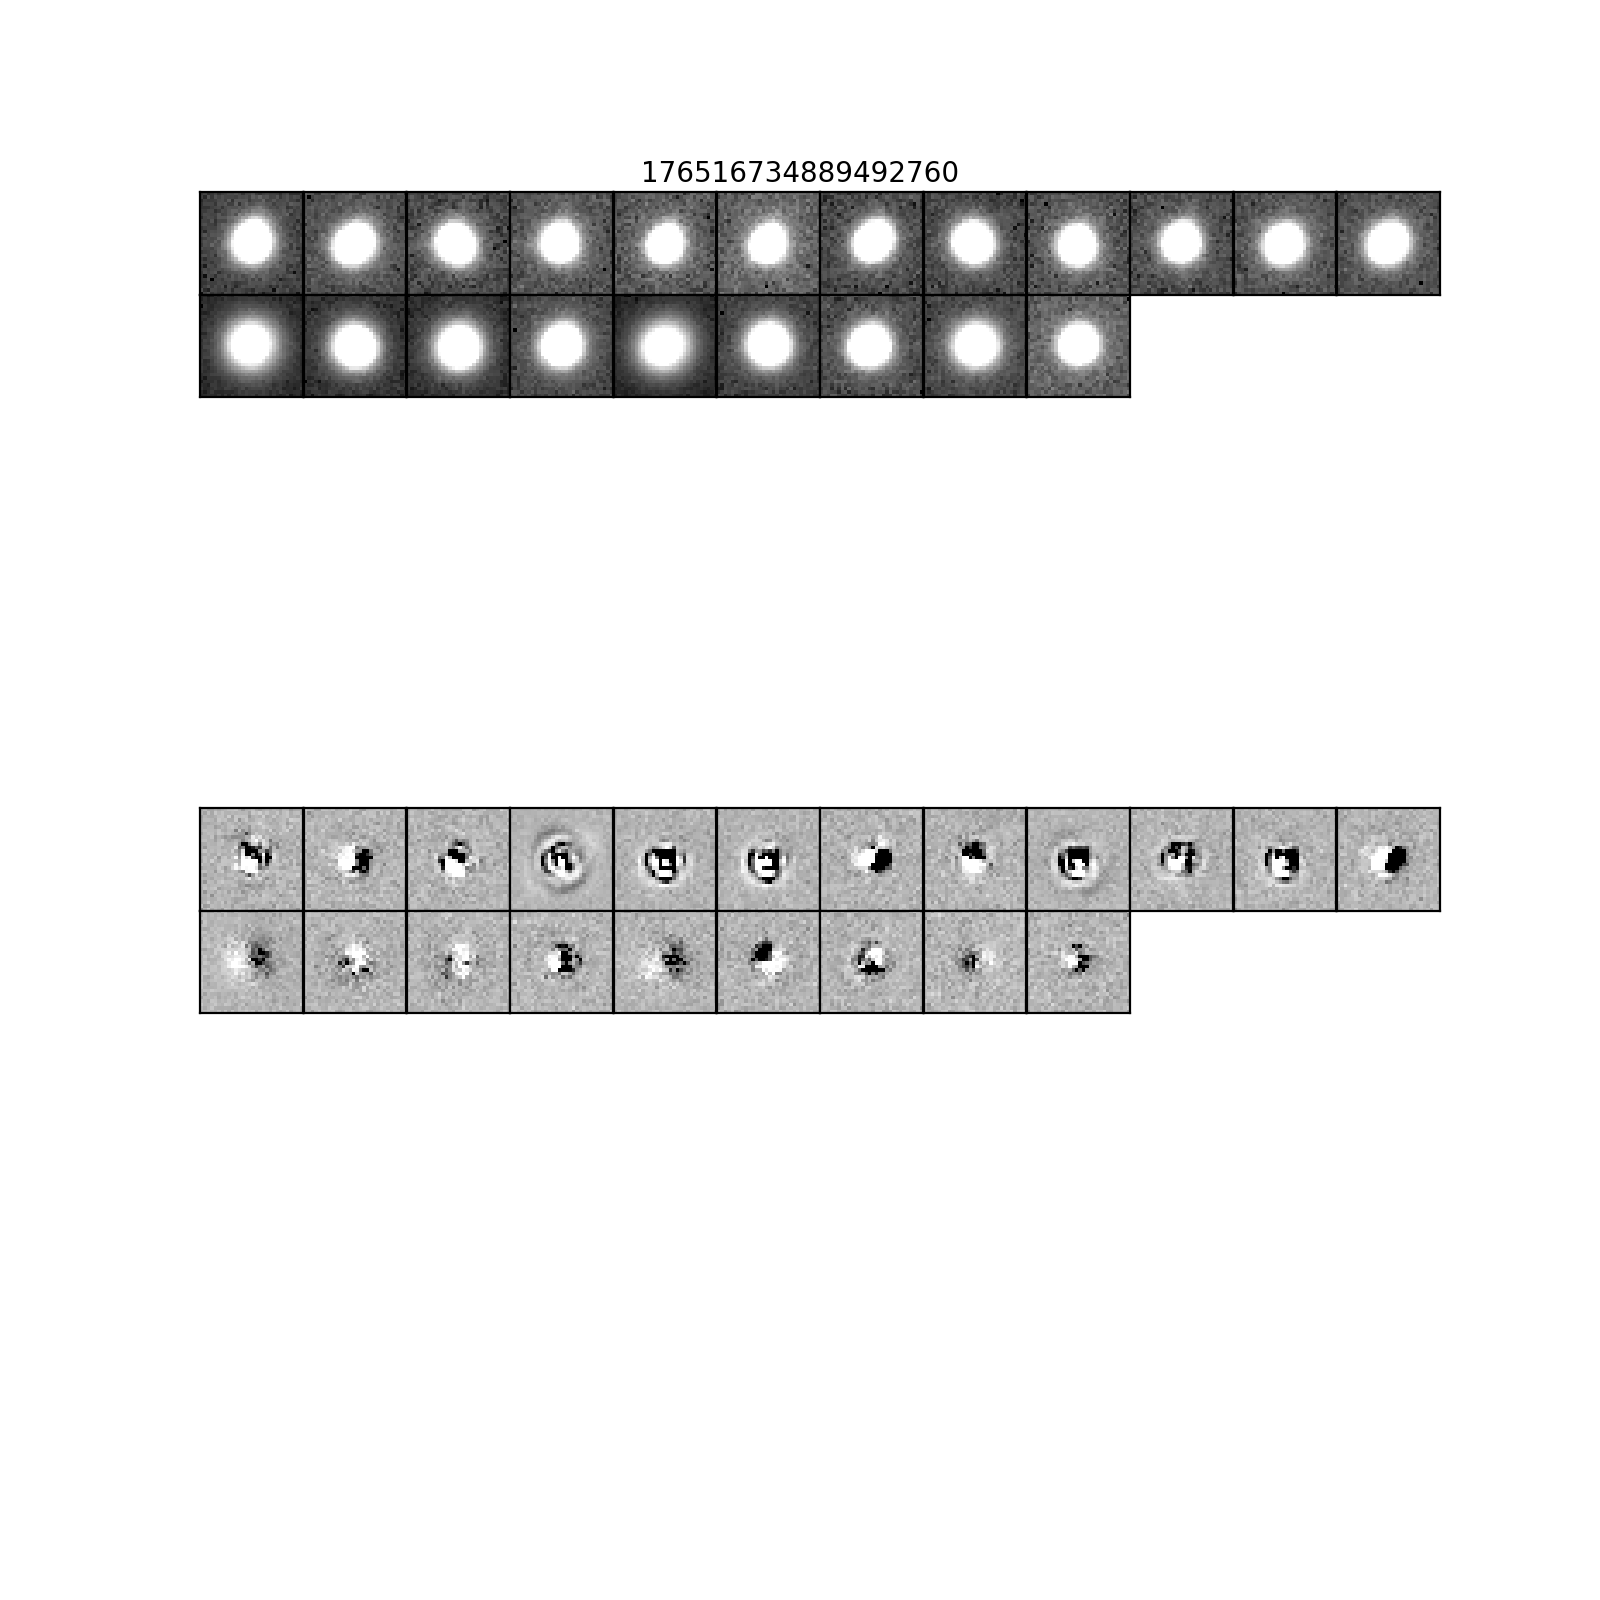

Loading PPDB Sources...
DIAObject ID: 176516756364329114
RA (deg): [155.06736401]
Dec (deg): [-5.89766196]
Number of DIASources: 24
Template patch: 11,7


<IPython.core.display.Javascript object>


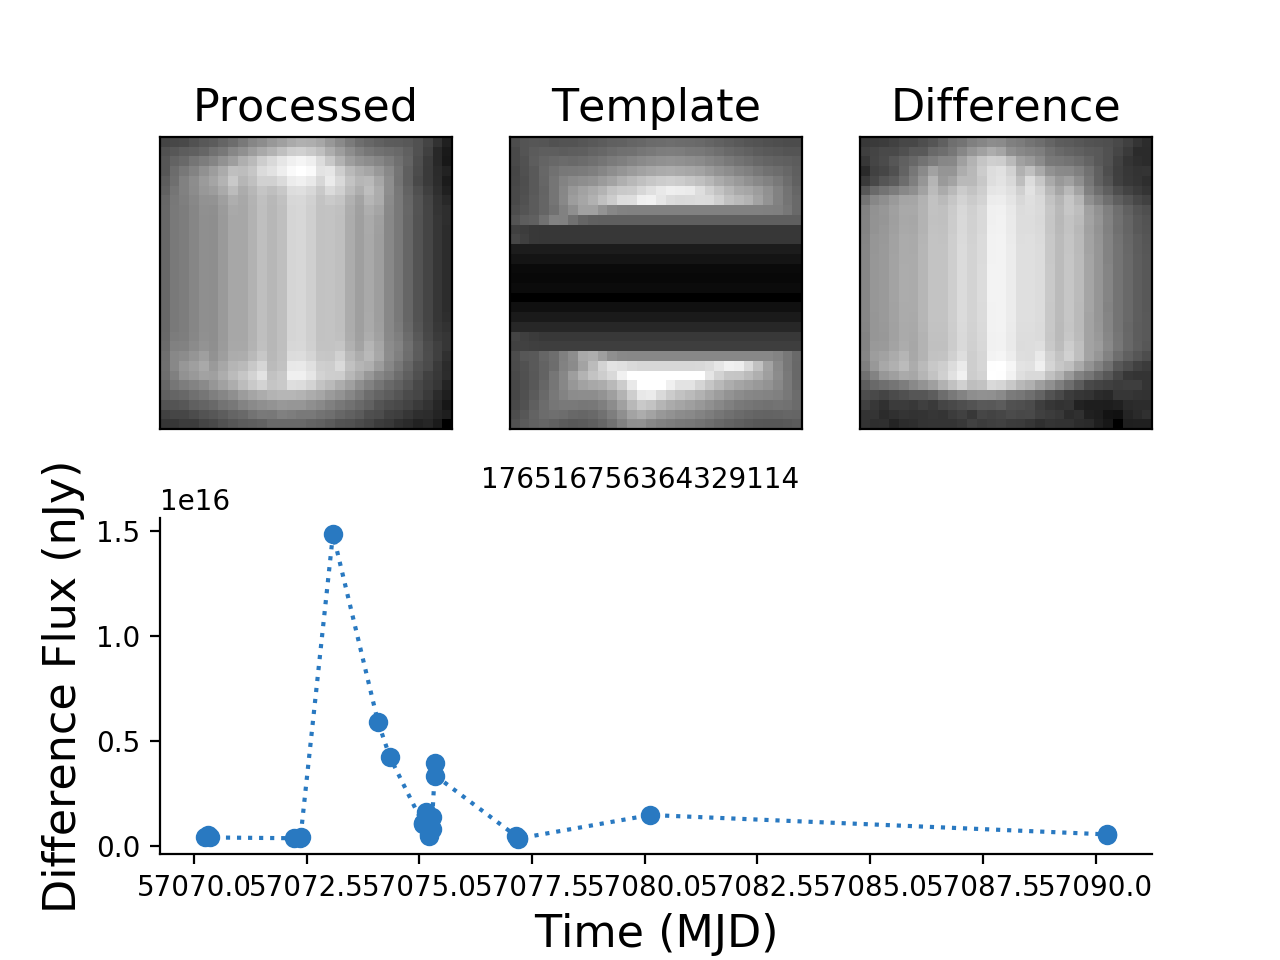

<IPython.core.display.Javascript object>


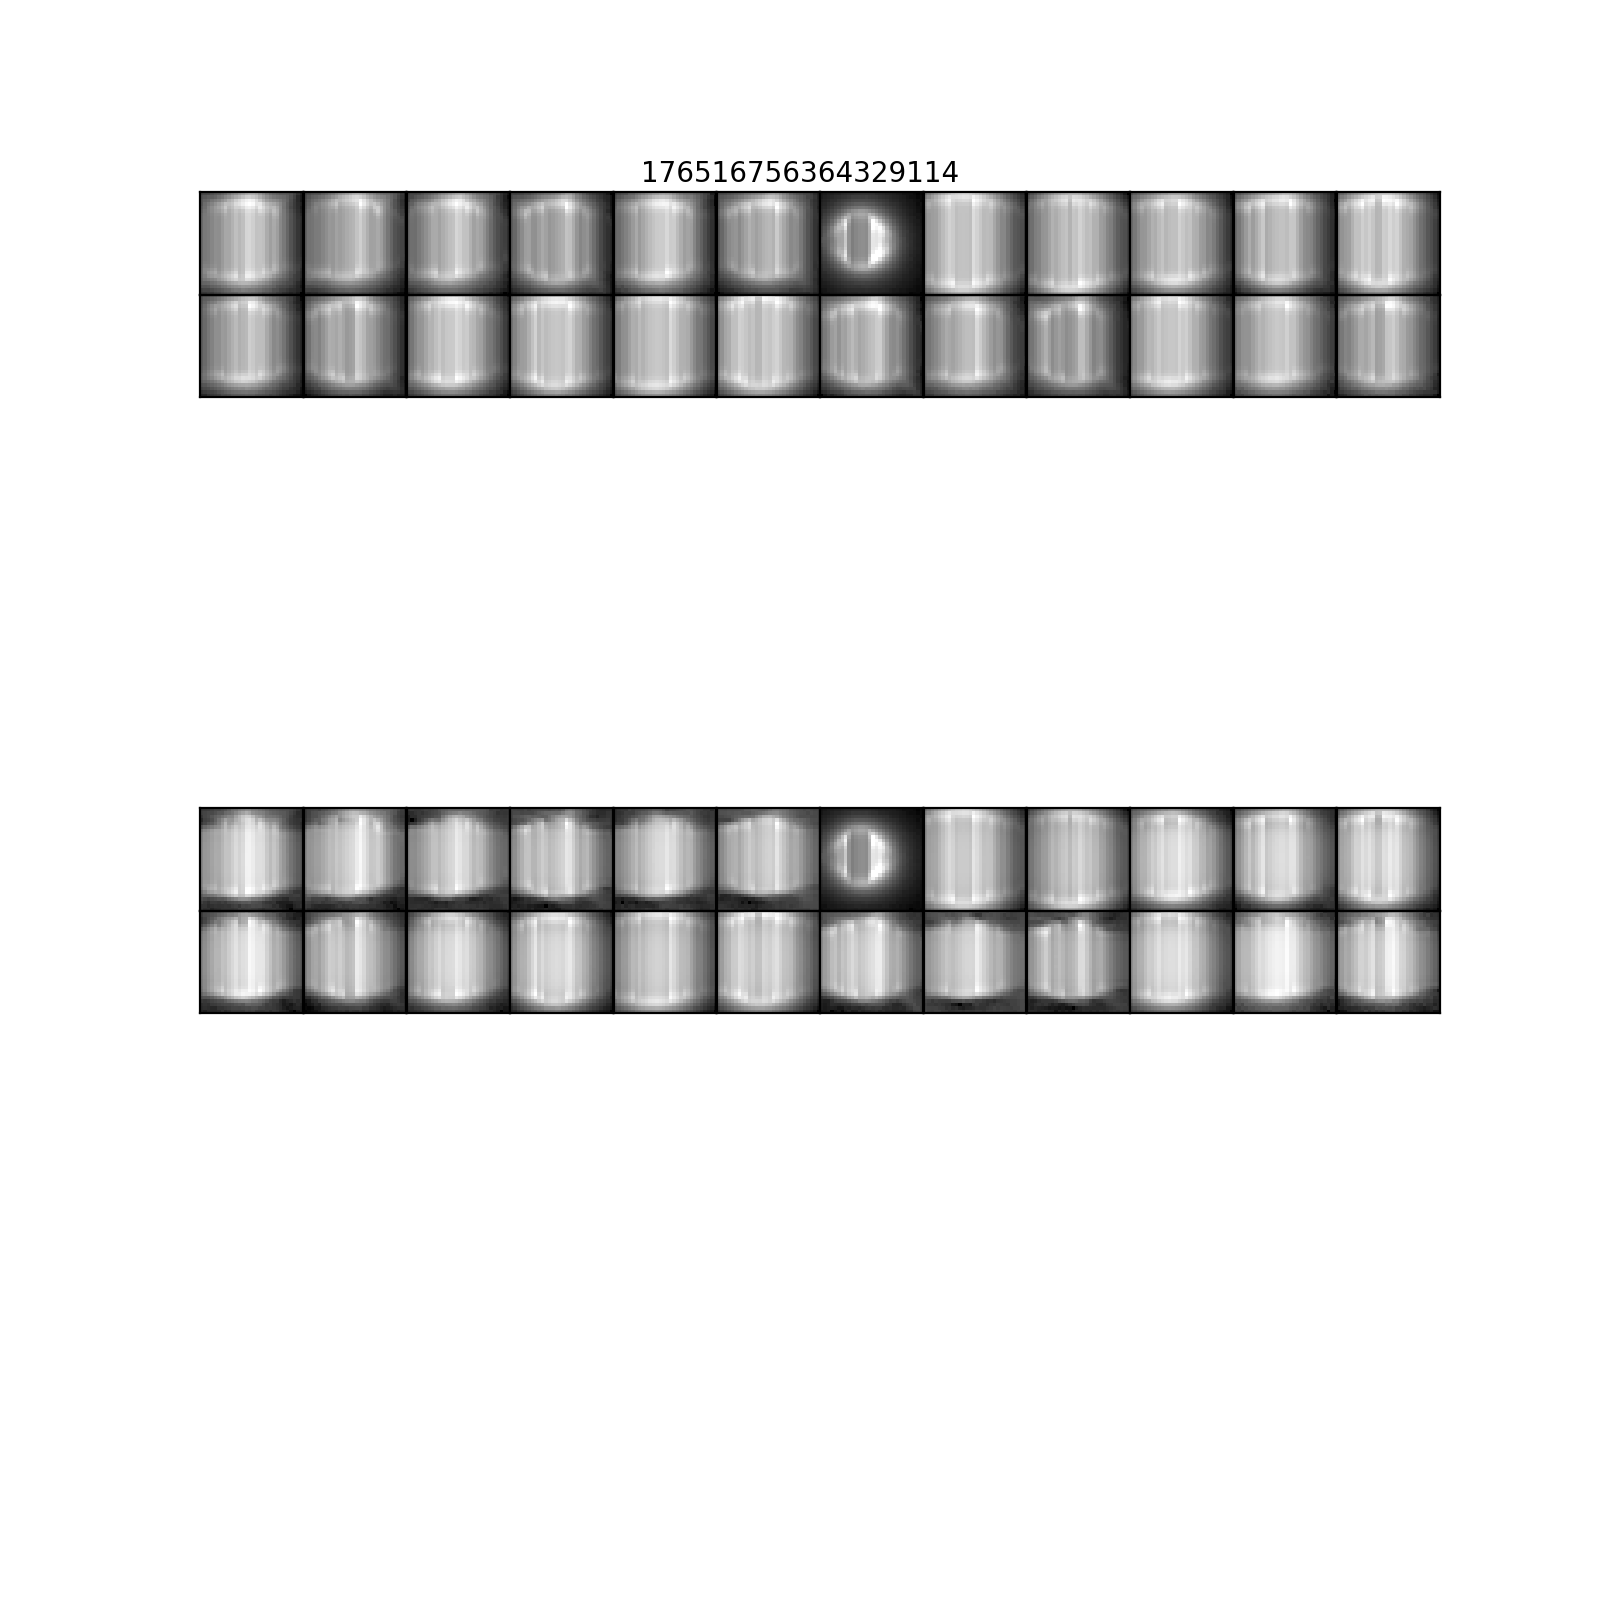

Loading PPDB Sources...
DIAObject ID: 176492665892766097
RA (deg): [154.80764002]
Dec (deg): [-5.62242369]
Number of DIASources: 26
Template patch: 12,8


/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


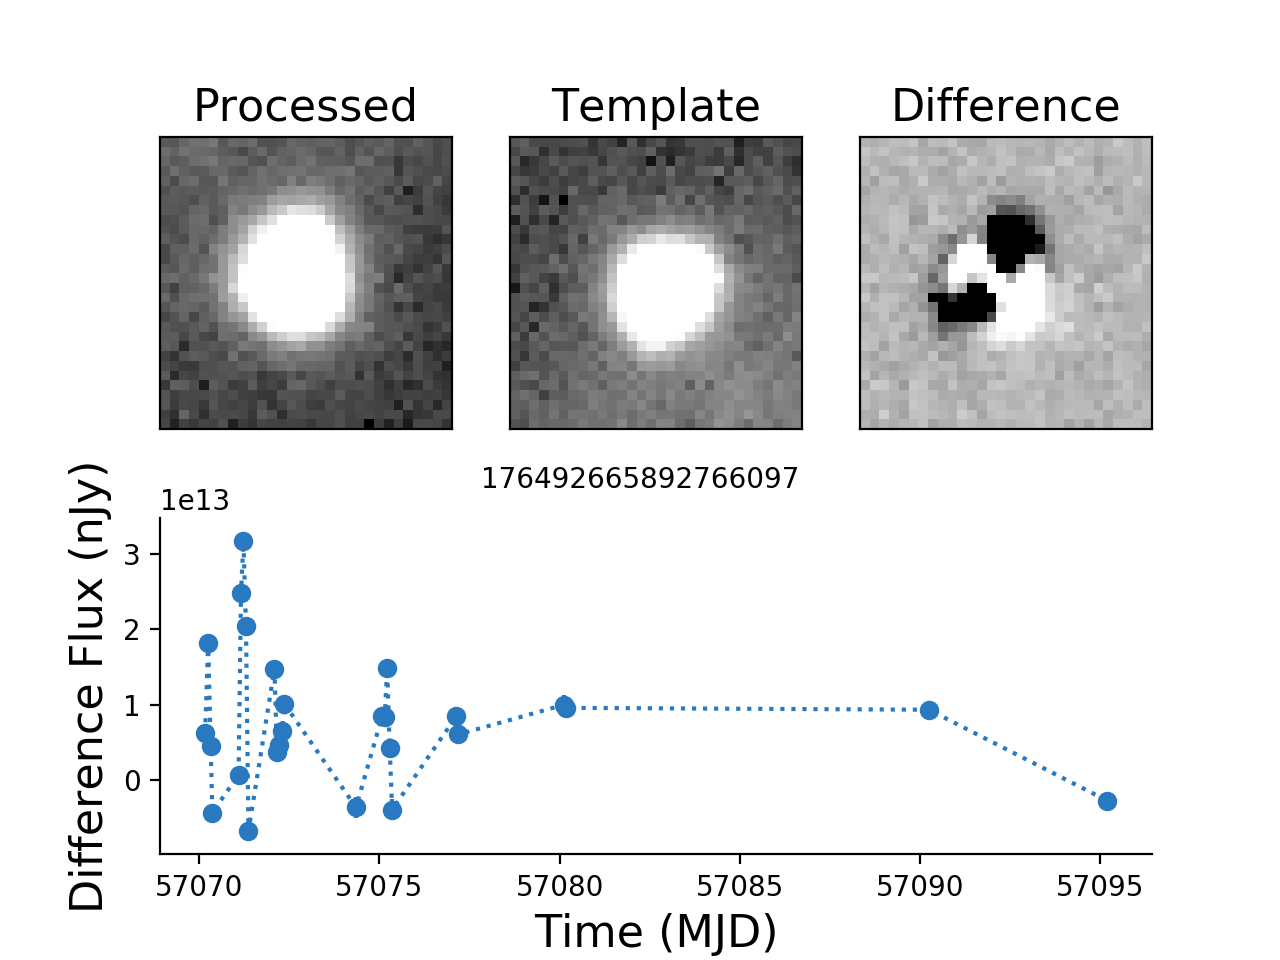

<IPython.core.display.Javascript object>


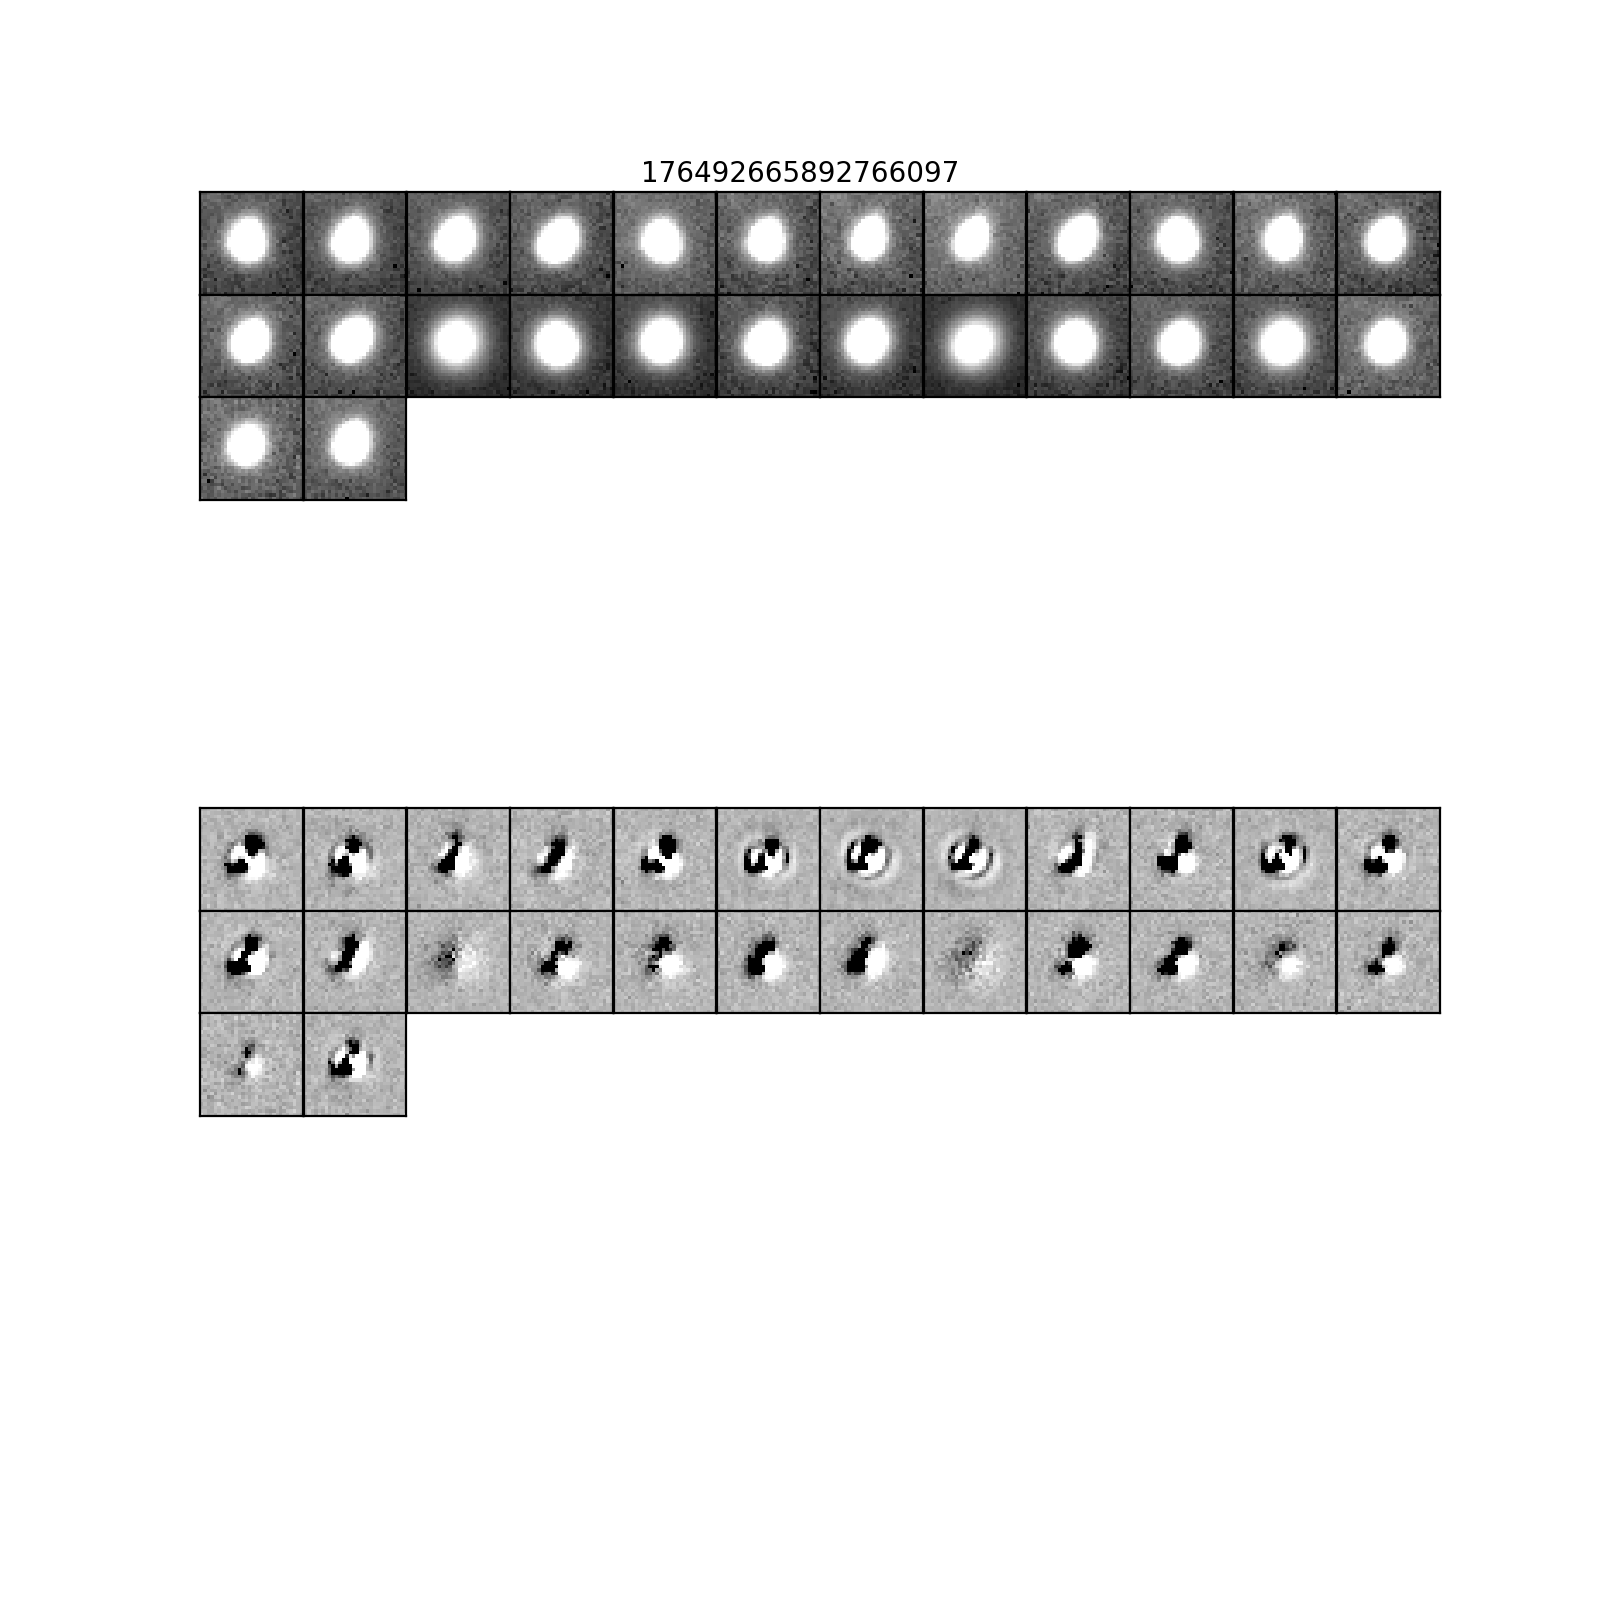

Loading PPDB Sources...
DIAObject ID: 176492665892766107
RA (deg): [154.83132555]
Dec (deg): [-5.64825738]
Number of DIASources: 25
Template patch: 12,8


<IPython.core.display.Javascript object>


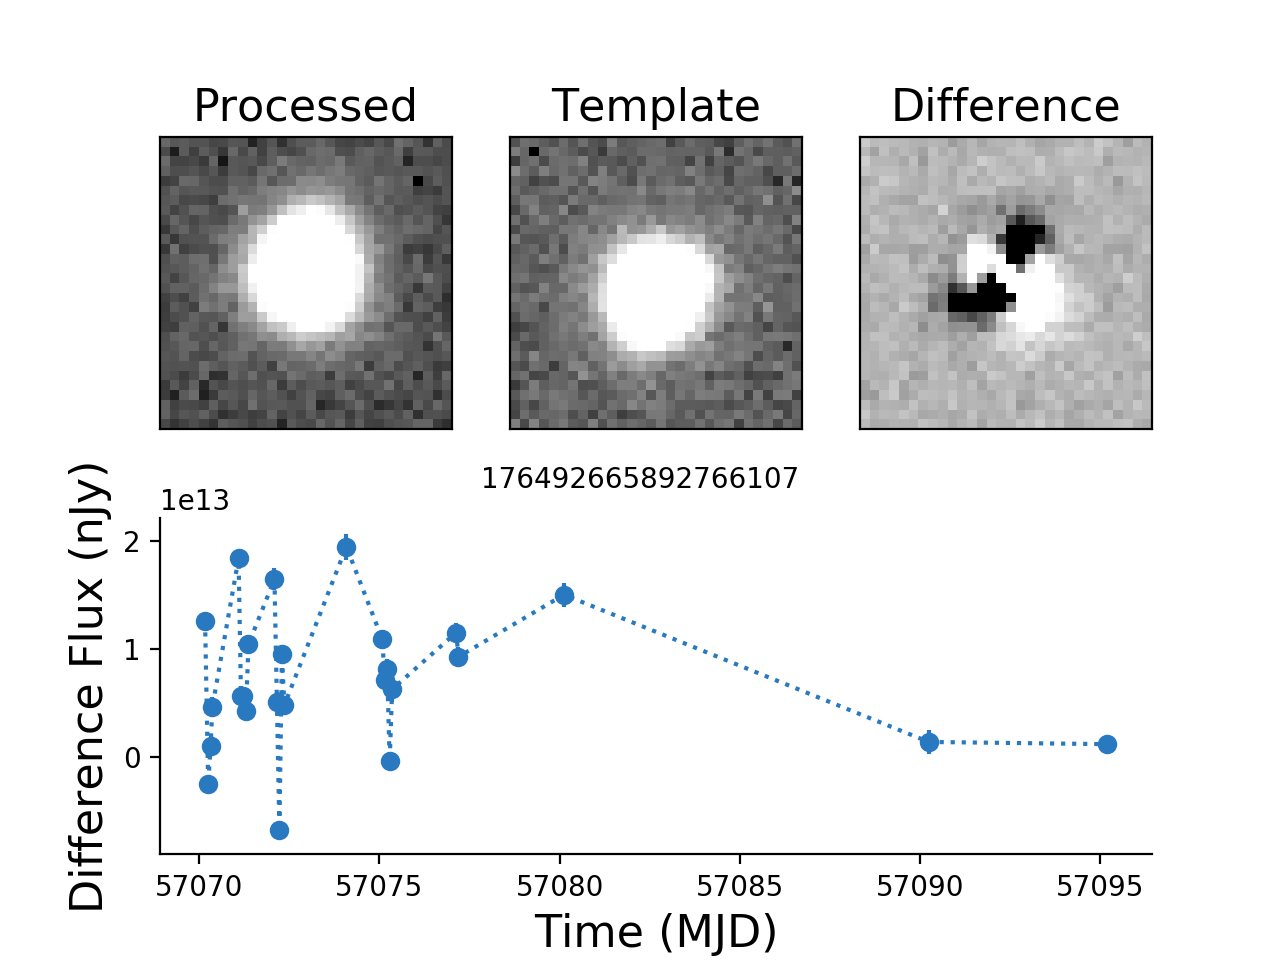

<IPython.core.display.Javascript object>


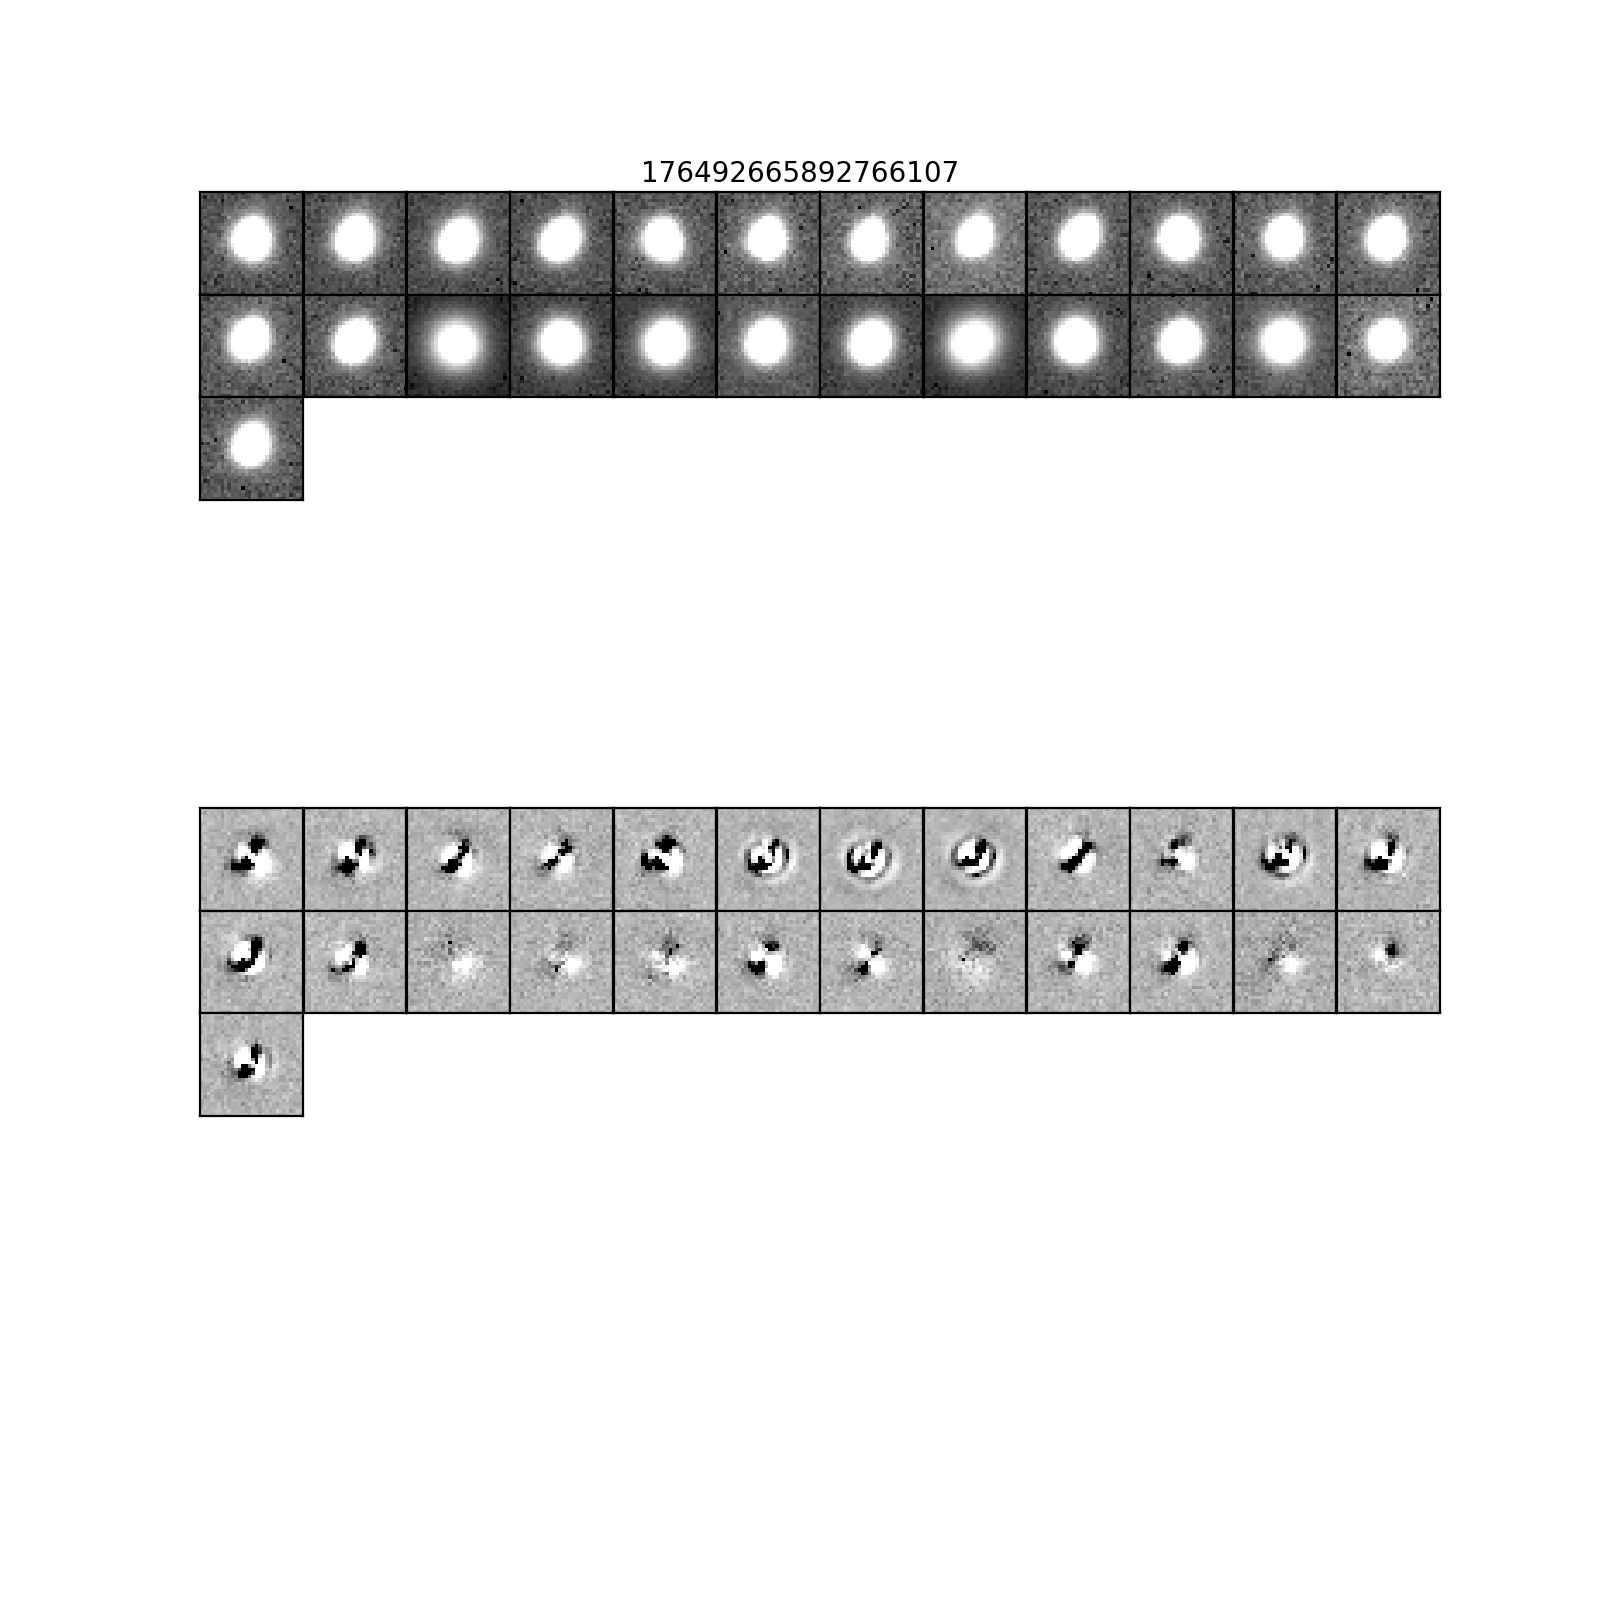

In [128]:
for obj in miniGoodObjDfNoDeconMult['diaObjectId'].values[0:5]:
    plc.plotLightcurve(obj, miniGoodObjDf, repo, dbPath, repo, patchList, plotAllCutouts=True)